In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [5]:
good_data_file = 'normedRateAvg2_data.pickle'
bad_data_file = 'normedRateAvg2_bad.pickle'

subplot_size = [2,3]
fig_size = [20,20]

runs = [304125,304508,302263]

with open(good_data_file, 'rb') as handle:
    data = pickle.load(handle)
with open(bad_data_file, 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])

num_rates = len(x_train[0])
print(num_rates)

6


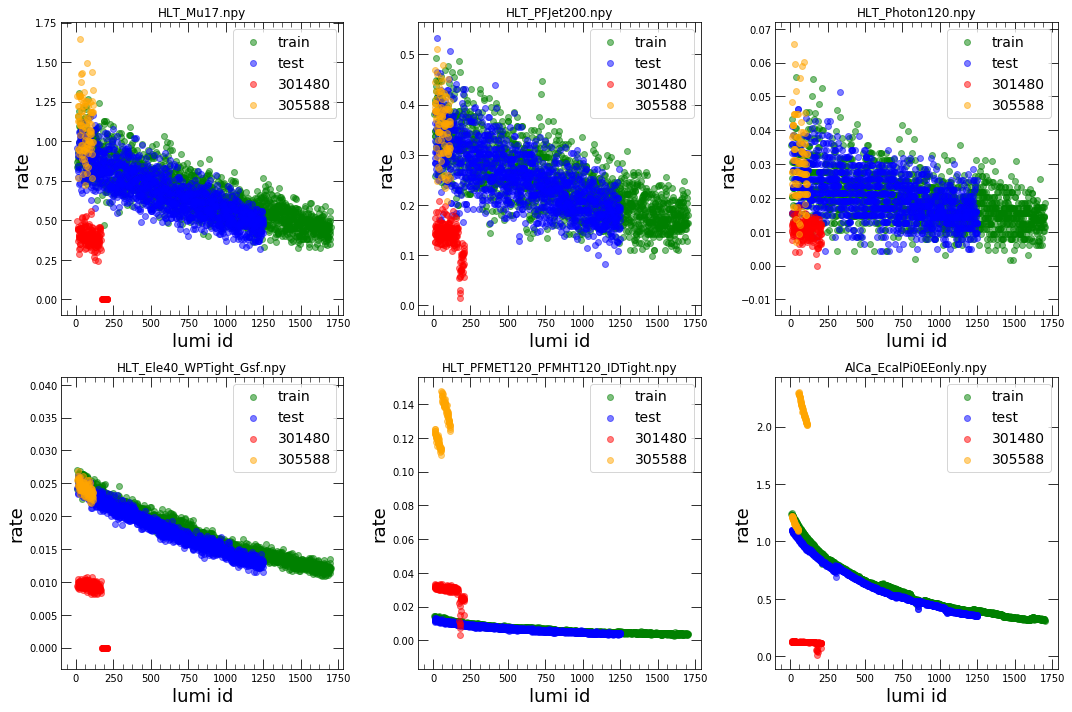

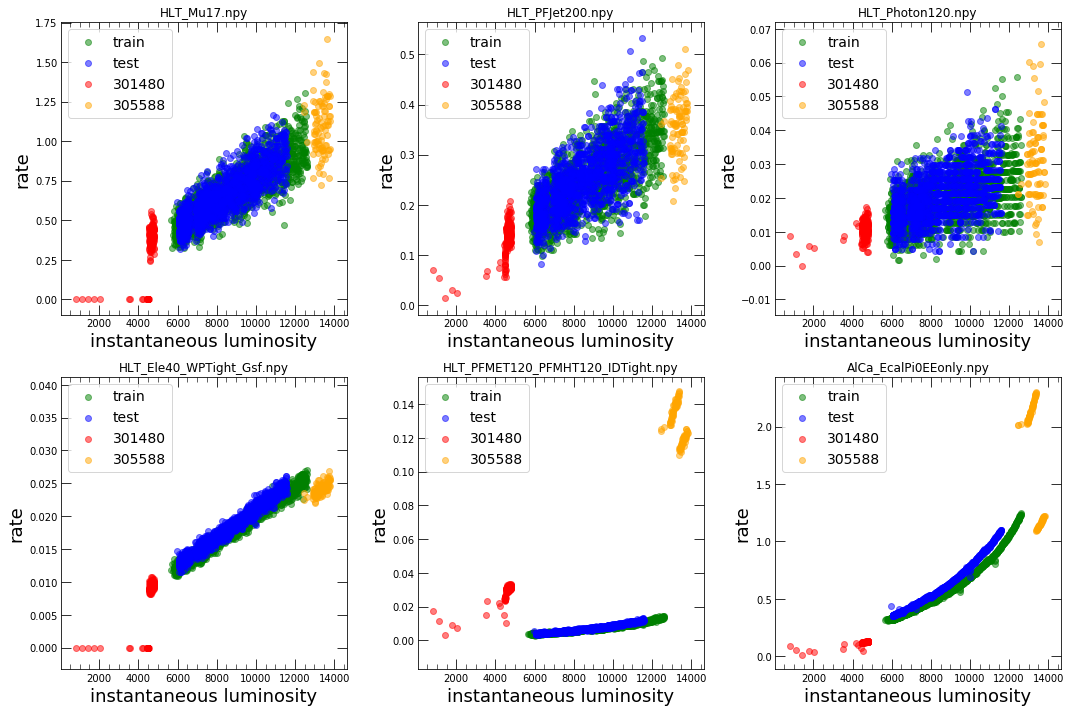

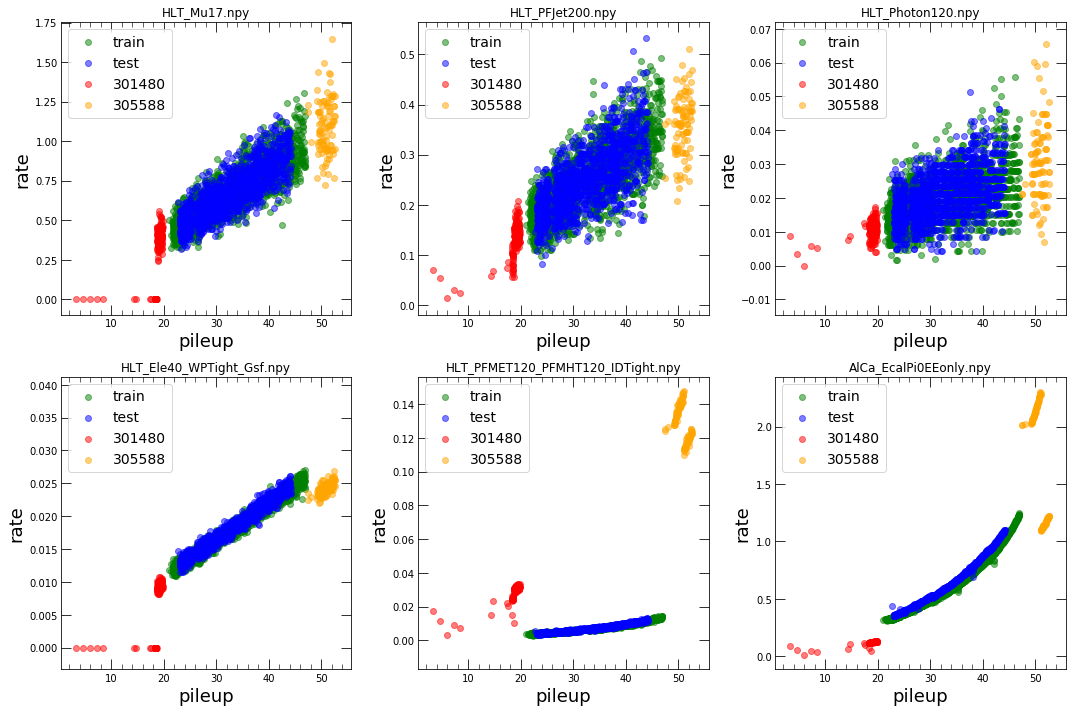

In [6]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [7]:
model_name = "normedRateAvgNoBatchNorm"

In [8]:
# Define the architecture

_input = Input(shape=(6,), name="input")

middle = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middle")(_input)

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(middle)

middle2 = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middle2")(hidden)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(middle2)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
middle (Dense)               (None, 5)                 35        
_________________________________________________________________
encoded (Dense)              (None, 3)                 18        
_________________________________________________________________
middle2 (Dense)              (None, 5)                 20        
_________________________________________________________________
reconstructed (Dense)        (None, 6)                 36        
Total params: 109
Trainable params: 109
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 2s - loss: 22152.0707 - val_loss: 22221.3609
Epoch 2/1000
 - 0s - loss: 21120.0959 - val_loss: 21249.0234
Epoch 3/1000
 - 0s - loss: 20192.6350 - val_loss: 20263.0584
Epoch 4/1000
 - 0s - loss: 19245.7869 - val_loss: 19302.2206
Epoch 5/1000
 - 0s - loss: 18334.1919 - val_loss: 18389.5283
Epoch 6/1000
 - 0s - loss: 17465.8907 - val_loss: 17520.5589
Epoch 7/1000
 - 0s - loss: 16646.3117 - val_loss: 16694.7164
Epoch 8/1000
 - 0s - loss: 15853.2947 - val_loss: 15907.1147
Epoch 9/1000
 - 0s - loss: 15108.4529 - val_loss: 15162.3834
Epoch 10/1000
 - 0s - loss: 14399.8166 - val_loss: 14457.3700
Epoch 11/1000
 - 0s - loss: 13734.1055 - val_loss: 13786.6518
Epoch 12/1000
 - 0s - loss: 13095.0624 - val_loss: 13153.2375
Epoch 13/1000
 - 0s - loss: 12498.0472 - val_loss: 12558.2862
Epoch 14/1000
 - 0s - loss: 11933.6063 - val_loss: 12000.4173
Epoch 15/1000
 - 0s - loss: 11403.8162 - val_loss: 11470.8928
Epoch 16/1000
 - 0s - loss: 109

Epoch 137/1000
 - 0s - loss: 700.1803 - val_loss: 722.8362
Epoch 138/1000
 - 0s - loss: 691.2798 - val_loss: 713.6639
Epoch 139/1000
 - 0s - loss: 682.4223 - val_loss: 704.6672
Epoch 140/1000
 - 0s - loss: 673.8582 - val_loss: 695.8280
Epoch 141/1000
 - 0s - loss: 665.4142 - val_loss: 687.1458
Epoch 142/1000
 - 0s - loss: 657.1483 - val_loss: 678.6159
Epoch 143/1000
 - 0s - loss: 648.9754 - val_loss: 670.2494
Epoch 144/1000
 - 0s - loss: 641.0111 - val_loss: 662.0214
Epoch 145/1000
 - 0s - loss: 633.1589 - val_loss: 653.9489
Epoch 146/1000
 - 0s - loss: 625.4266 - val_loss: 646.0238
Epoch 147/1000
 - 0s - loss: 617.8463 - val_loss: 638.2314
Epoch 148/1000
 - 0s - loss: 610.4162 - val_loss: 630.5720
Epoch 149/1000
 - 0s - loss: 603.0678 - val_loss: 623.0532
Epoch 150/1000
 - 0s - loss: 595.8968 - val_loss: 615.6579
Epoch 151/1000
 - 0s - loss: 588.8751 - val_loss: 608.3802
Epoch 152/1000
 - 0s - loss: 581.8552 - val_loss: 601.2325
Epoch 153/1000
 - 0s - loss: 575.0760 - val_loss: 594.20

Epoch 276/1000
 - 0s - loss: 187.5366 - val_loss: 194.4908
Epoch 277/1000
 - 0s - loss: 186.1860 - val_loss: 193.0947
Epoch 278/1000
 - 0s - loss: 184.8514 - val_loss: 191.7134
Epoch 279/1000
 - 0s - loss: 183.5153 - val_loss: 190.3473
Epoch 280/1000
 - 0s - loss: 182.2198 - val_loss: 188.9921
Epoch 281/1000
 - 0s - loss: 180.9261 - val_loss: 187.6496
Epoch 282/1000
 - 0s - loss: 179.6407 - val_loss: 186.3219
Epoch 283/1000
 - 0s - loss: 178.3592 - val_loss: 185.0087
Epoch 284/1000
 - 0s - loss: 177.1132 - val_loss: 183.7061
Epoch 285/1000
 - 0s - loss: 175.8744 - val_loss: 182.4169
Epoch 286/1000
 - 0s - loss: 174.6367 - val_loss: 181.1420
Epoch 287/1000
 - 0s - loss: 173.4062 - val_loss: 179.8813
Epoch 288/1000
 - 0s - loss: 172.2061 - val_loss: 178.6316
Epoch 289/1000
 - 0s - loss: 171.0128 - val_loss: 177.3936
Epoch 290/1000
 - 0s - loss: 169.8301 - val_loss: 176.1684
Epoch 291/1000
 - 0s - loss: 168.6537 - val_loss: 174.9562
Epoch 292/1000
 - 0s - loss: 167.4928 - val_loss: 173.75

Epoch 417/1000
 - 0s - loss: 80.0632 - val_loss: 83.1734
Epoch 418/1000
 - 0s - loss: 79.6554 - val_loss: 82.7493
Epoch 419/1000
 - 0s - loss: 79.2476 - val_loss: 82.3287
Epoch 420/1000
 - 0s - loss: 78.8470 - val_loss: 81.9110
Epoch 421/1000
 - 0s - loss: 78.4452 - val_loss: 81.4965
Epoch 422/1000
 - 0s - loss: 78.0489 - val_loss: 81.0848
Epoch 423/1000
 - 0s - loss: 77.6545 - val_loss: 80.6760
Epoch 424/1000
 - 0s - loss: 77.2620 - val_loss: 80.2701
Epoch 425/1000
 - 0s - loss: 76.8753 - val_loss: 79.8667
Epoch 426/1000
 - 0s - loss: 76.4904 - val_loss: 79.4662
Epoch 427/1000
 - 0s - loss: 76.1037 - val_loss: 79.0690
Epoch 428/1000
 - 0s - loss: 75.7258 - val_loss: 78.6741
Epoch 429/1000
 - 0s - loss: 75.3464 - val_loss: 78.2823
Epoch 430/1000
 - 0s - loss: 74.9699 - val_loss: 77.8930
Epoch 431/1000
 - 0s - loss: 74.6007 - val_loss: 77.5059
Epoch 432/1000
 - 0s - loss: 74.2283 - val_loss: 77.1221
Epoch 433/1000
 - 0s - loss: 73.8601 - val_loss: 76.7408
Epoch 434/1000
 - 0s - loss: 73

Epoch 561/1000
 - 0s - loss: 41.7651 - val_loss: 43.4252
Epoch 562/1000
 - 0s - loss: 41.5970 - val_loss: 43.2509
Epoch 563/1000
 - 0s - loss: 41.4299 - val_loss: 43.0777
Epoch 564/1000
 - 0s - loss: 41.2650 - val_loss: 42.9056
Epoch 565/1000
 - 0s - loss: 41.0996 - val_loss: 42.7345
Epoch 566/1000
 - 0s - loss: 40.9348 - val_loss: 42.5646
Epoch 567/1000
 - 0s - loss: 40.7717 - val_loss: 42.3954
Epoch 568/1000
 - 0s - loss: 40.6104 - val_loss: 42.2269
Epoch 569/1000
 - 0s - loss: 40.4503 - val_loss: 42.0592
Epoch 570/1000
 - 0s - loss: 40.2884 - val_loss: 41.8928
Epoch 571/1000
 - 0s - loss: 40.1288 - val_loss: 41.7272
Epoch 572/1000
 - 0s - loss: 39.9703 - val_loss: 41.5624
Epoch 573/1000
 - 0s - loss: 39.8122 - val_loss: 41.3983
Epoch 574/1000
 - 0s - loss: 39.6554 - val_loss: 41.2351
Epoch 575/1000
 - 0s - loss: 39.4983 - val_loss: 41.0727
Epoch 576/1000
 - 0s - loss: 39.3432 - val_loss: 40.9110
Epoch 577/1000
 - 0s - loss: 39.1897 - val_loss: 40.7501
Epoch 578/1000
 - 0s - loss: 39

Epoch 705/1000
 - 0s - loss: 24.6064 - val_loss: 25.5985
Epoch 706/1000
 - 0s - loss: 24.5237 - val_loss: 25.5124
Epoch 707/1000
 - 0s - loss: 24.4405 - val_loss: 25.4267
Epoch 708/1000
 - 0s - loss: 24.3590 - val_loss: 25.3411
Epoch 709/1000
 - 0s - loss: 24.2772 - val_loss: 25.2560
Epoch 710/1000
 - 0s - loss: 24.1959 - val_loss: 25.1713
Epoch 711/1000
 - 0s - loss: 24.1146 - val_loss: 25.0871
Epoch 712/1000
 - 0s - loss: 24.0333 - val_loss: 25.0032
Epoch 713/1000
 - 0s - loss: 23.9533 - val_loss: 24.9197
Epoch 714/1000
 - 0s - loss: 23.8736 - val_loss: 24.8364
Epoch 715/1000
 - 0s - loss: 23.7938 - val_loss: 24.7535
Epoch 716/1000
 - 0s - loss: 23.7142 - val_loss: 24.6711
Epoch 717/1000
 - 0s - loss: 23.6360 - val_loss: 24.5890
Epoch 718/1000
 - 0s - loss: 23.5568 - val_loss: 24.5074
Epoch 719/1000
 - 0s - loss: 23.4783 - val_loss: 24.4262
Epoch 720/1000
 - 0s - loss: 23.4008 - val_loss: 24.3452
Epoch 721/1000
 - 0s - loss: 23.3234 - val_loss: 24.2646
Epoch 722/1000
 - 0s - loss: 23

Epoch 849/1000
 - 0s - loss: 15.6403 - val_loss: 16.2763
Epoch 850/1000
 - 0s - loss: 15.5942 - val_loss: 16.2285
Epoch 851/1000
 - 0s - loss: 15.5483 - val_loss: 16.1809
Epoch 852/1000
 - 0s - loss: 15.5029 - val_loss: 16.1333
Epoch 853/1000
 - 0s - loss: 15.4574 - val_loss: 16.0860
Epoch 854/1000
 - 0s - loss: 15.4120 - val_loss: 16.0389
Epoch 855/1000
 - 0s - loss: 15.3669 - val_loss: 15.9919
Epoch 856/1000
 - 0s - loss: 15.3218 - val_loss: 15.9452
Epoch 857/1000
 - 0s - loss: 15.2771 - val_loss: 15.8986
Epoch 858/1000
 - 0s - loss: 15.2325 - val_loss: 15.8521
Epoch 859/1000
 - 0s - loss: 15.1881 - val_loss: 15.8059
Epoch 860/1000
 - 0s - loss: 15.1435 - val_loss: 15.7598
Epoch 861/1000
 - 0s - loss: 15.0995 - val_loss: 15.7139
Epoch 862/1000
 - 0s - loss: 15.0555 - val_loss: 15.6682
Epoch 863/1000
 - 0s - loss: 15.0117 - val_loss: 15.6226
Epoch 864/1000
 - 0s - loss: 14.9679 - val_loss: 15.5772
Epoch 865/1000
 - 0s - loss: 14.9243 - val_loss: 15.5319
Epoch 866/1000
 - 0s - loss: 14

Epoch 993/1000
 - 0s - loss: 10.4664 - val_loss: 10.8945
Epoch 994/1000
 - 0s - loss: 10.4388 - val_loss: 10.8657
Epoch 995/1000
 - 0s - loss: 10.4111 - val_loss: 10.8370
Epoch 996/1000
 - 0s - loss: 10.3838 - val_loss: 10.8084
Epoch 997/1000
 - 0s - loss: 10.3563 - val_loss: 10.7800
Epoch 998/1000
 - 0s - loss: 10.3290 - val_loss: 10.7516
Epoch 999/1000
 - 0s - loss: 10.3019 - val_loss: 10.7233
Epoch 1000/1000
 - 0s - loss: 10.2747 - val_loss: 10.6951


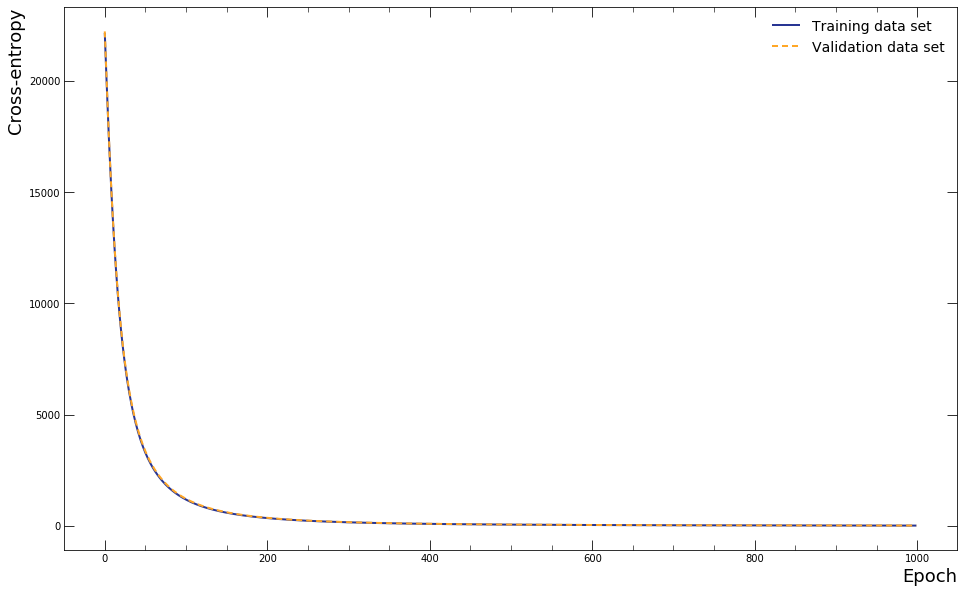

In [9]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

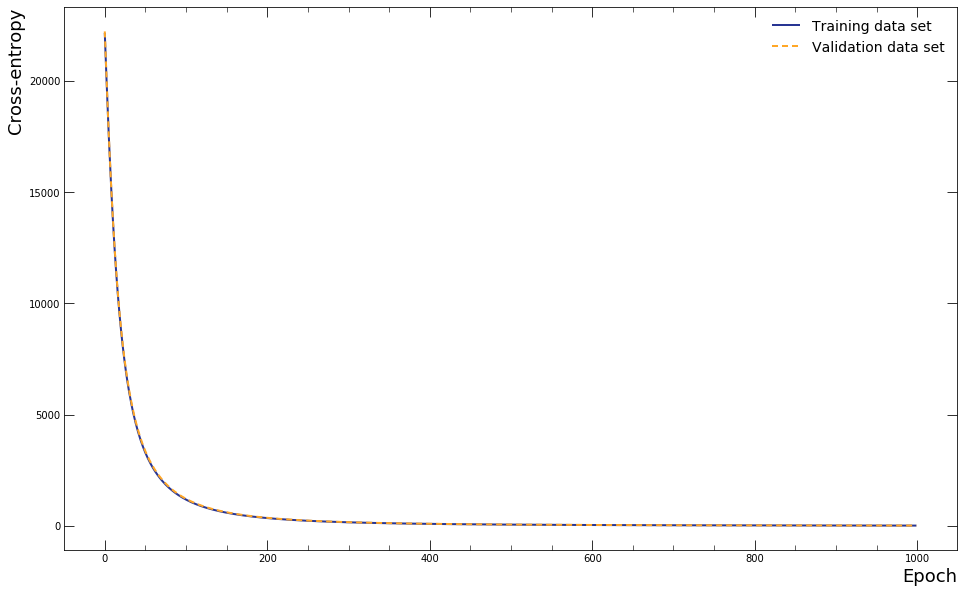

In [10]:
plot_loss(history)

## Training Set

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

lumi_train = data[str(runs[0])]['lumiid'] 
             
reconstructed_train = model.predict(np.array(x_train))

error = abs(x_train-reconstructed_train)/x_train

In [12]:
error_train_reformat = []
inp = []
outp = []
for i in range(num_rates):
    error_train_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    for j in range(num_rates):
        error_train_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_train[i][j])
        inp[j].append(x_train[i][j])

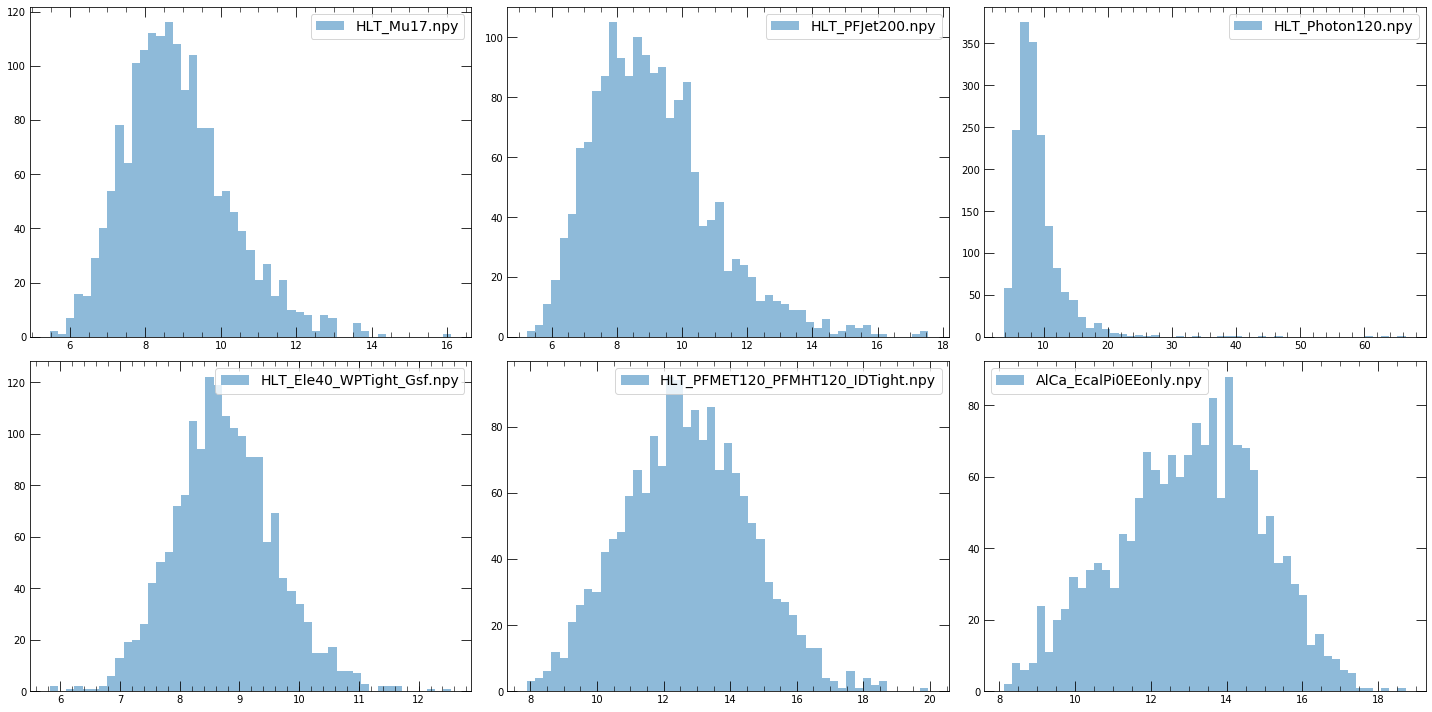

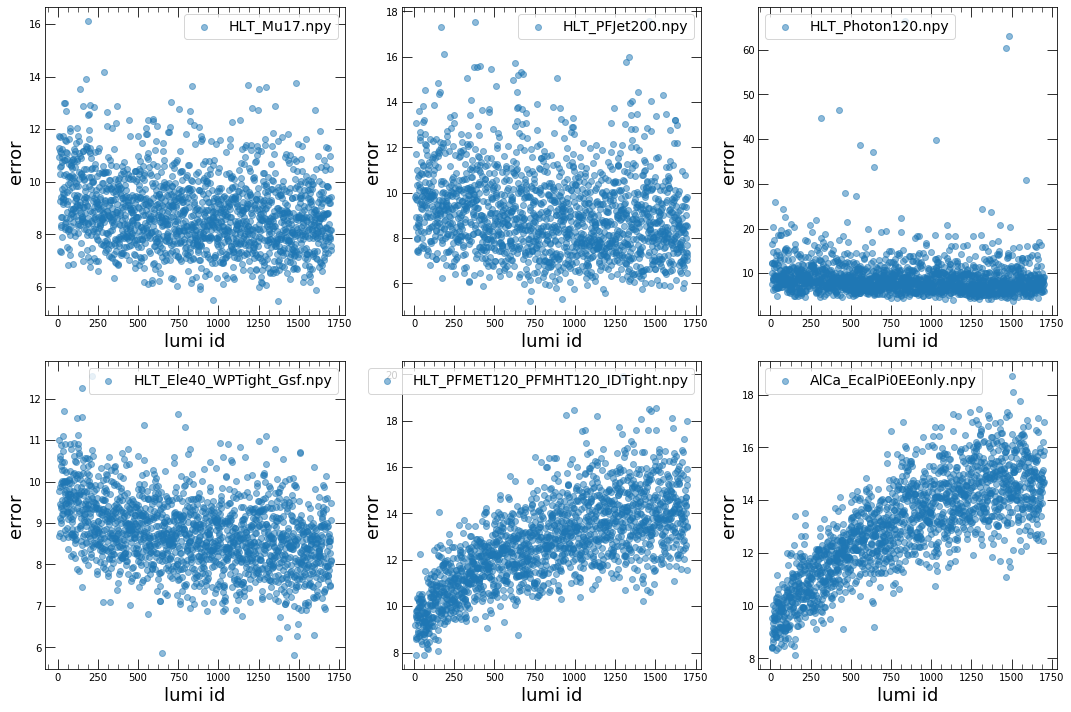

In [13]:
labels = data['HLT']
#bins = np.linspace(0,1,50)

bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_train_reformat)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_train_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
plt.tight_layout()

#lumi_train = np.linspace(0,len(error_train_reformat0]),len(error_train_reformat0]))
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_train,error_train_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
plt.tight_layout()
plt.show()

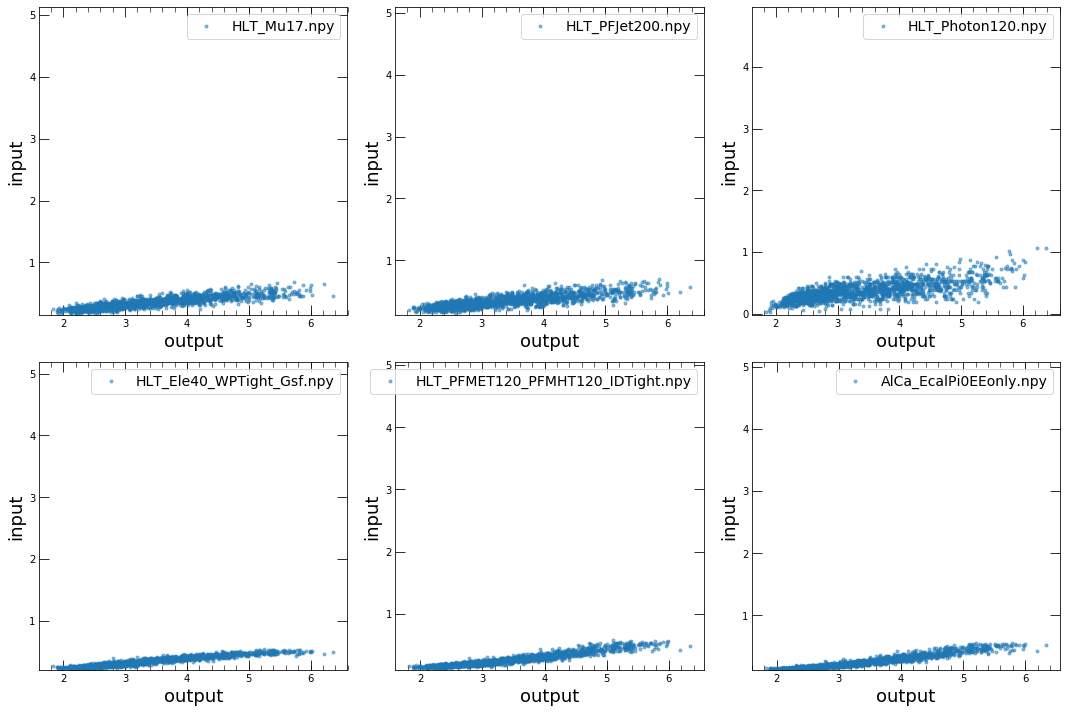

In [14]:
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_train,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend() 
    
    plt.axis('square')

plt.tight_layout()
plt.show()

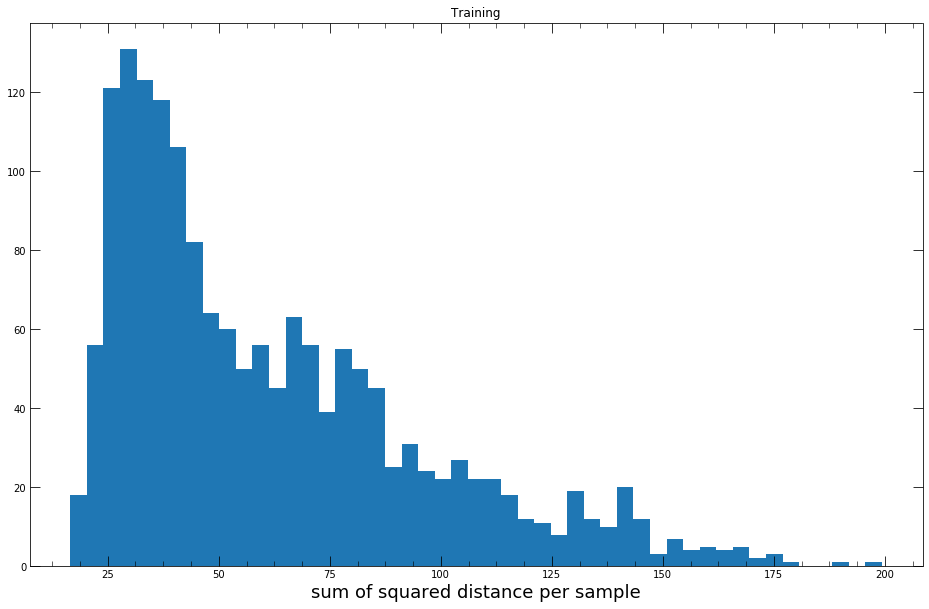

In [15]:
error_train = []
for r in range(len(reconstructed_train)):
    temp = 0
    for s in range(len(reconstructed_train[r])):
        temp+=(reconstructed_train[r][s]-x_train[r][s])**2
    error_train.append(temp)

bins = np.linspace(min(error_train),max(error_train),50)
plt.figure()
plt.hist(error_train,bins=bins)
plt.xlabel('sum of squared distance per sample')
plt.title('Training')
plt.show()

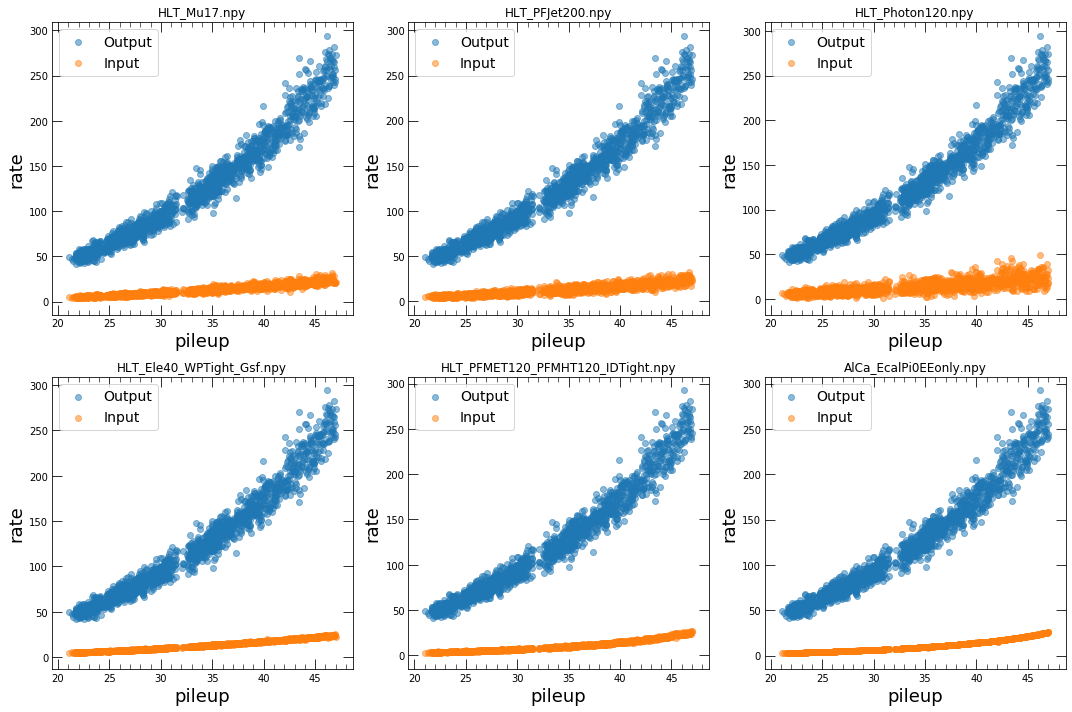

In [16]:
pileup_train = data[str(runs[0])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_train)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_train[r][o]*pileup_train[r])
        input_rates[o].append(x_train[r][o]*pileup_train[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_train,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_train,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Test Data

In [17]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

reconstructed_test = model.predict(np.array(x_test))

error = abs(x_test-reconstructed_test)/x_test

In [18]:
error_test_reformat = []
inp = []
outp = []
for i in range(num_rates):
    error_test_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    #print(len(error_test_reformat[0]))
    for j in range(num_rates):
        error_test_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_test[i][j])
        inp[j].append(x_test[i][j])

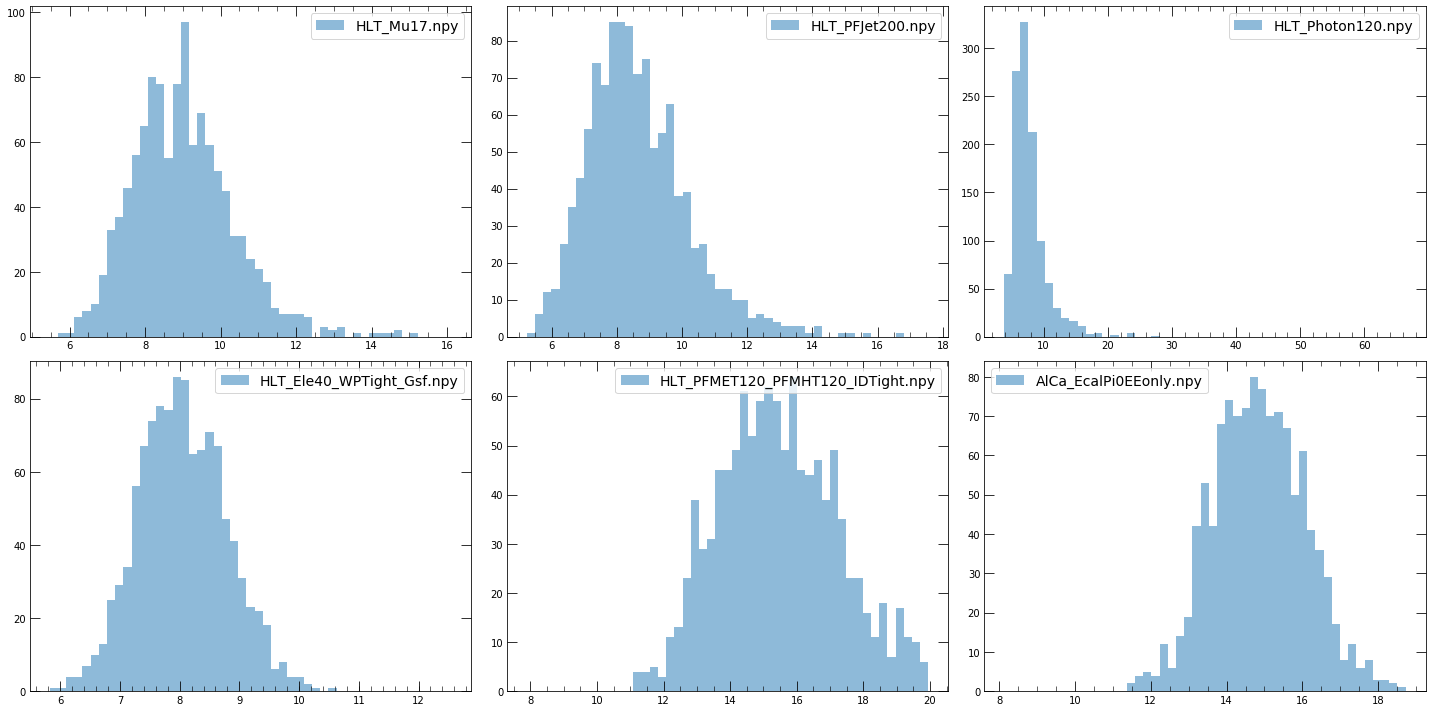

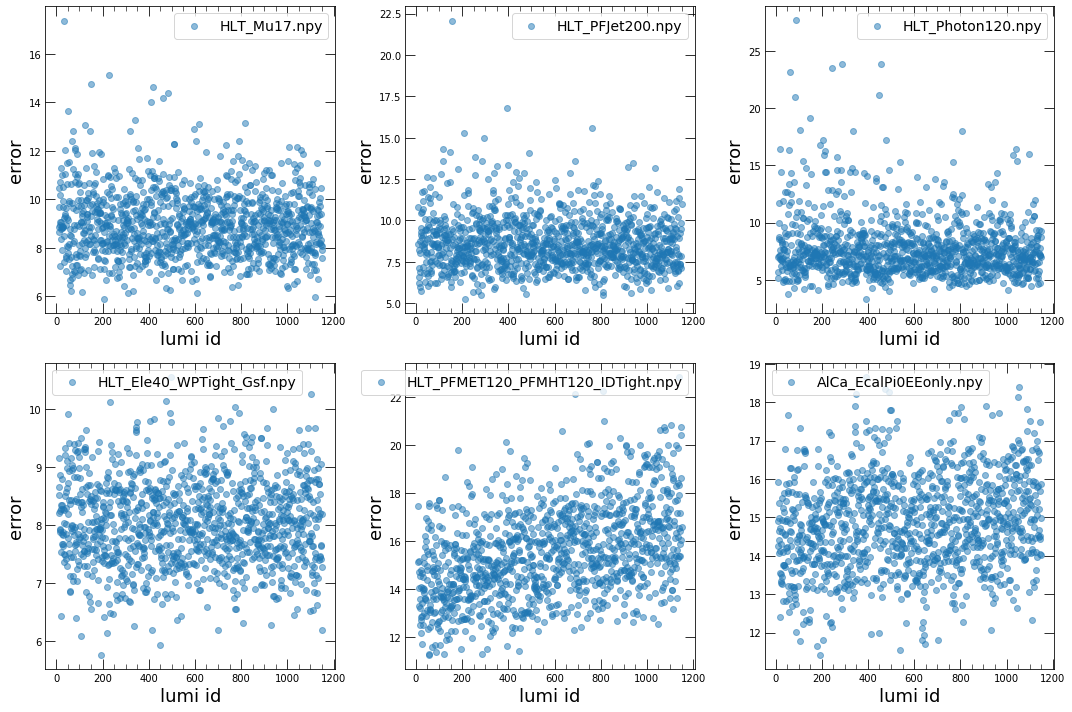

In [19]:
#bins = np.linspace(0,1,50)
plt.figure(figsize=[20,10])
for i in range(len(error_test_reformat)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_test_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

lumi_test = data[str(runs[2])]['lumiid']
#lumi_test = np.linspace(0,len(error_test_reformat[0]),len(error_test_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()
plt.show()

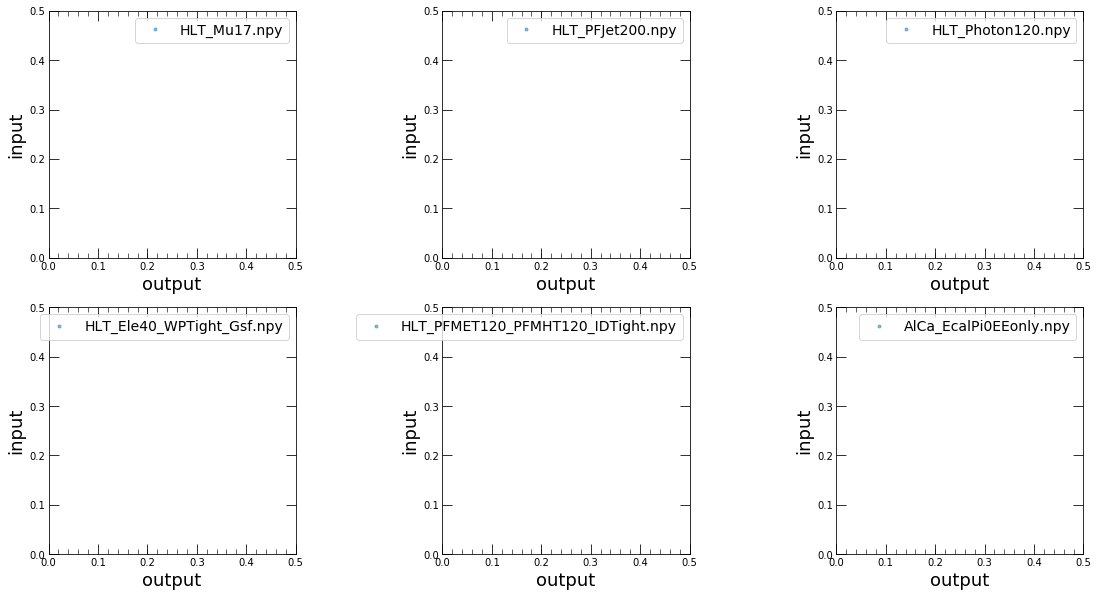

In [20]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_test,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,.5)
    plt.ylim(0,.5)
    plt.legend()    

plt.show()

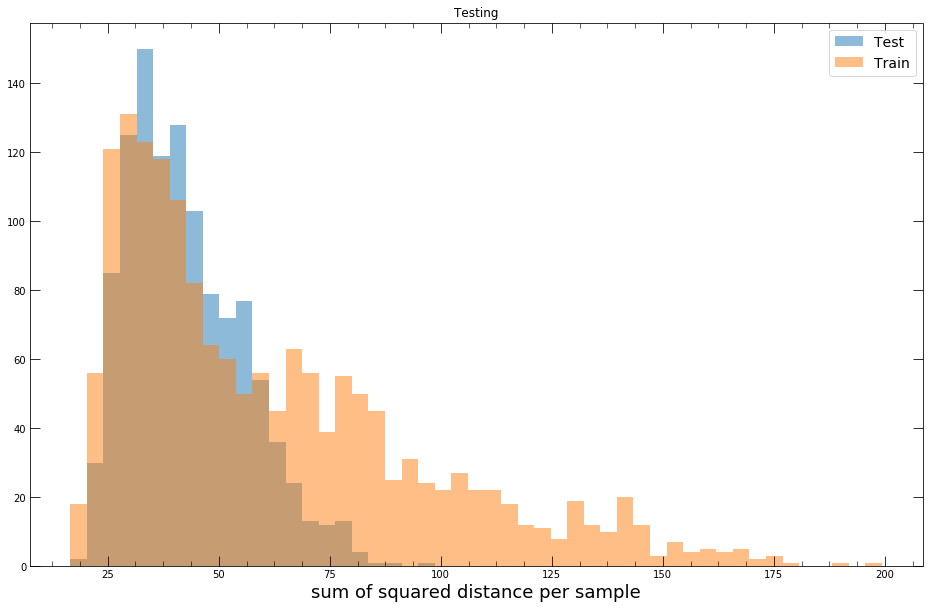

In [21]:
error_test = []
for r in range(len(reconstructed_test)):
    temp = 0
    for s in range(len(reconstructed_test[r])):
        temp+=(reconstructed_test[r][s]-x_test[r][s])**2
    error_test.append(temp)

plt.figure()
bins = np.linspace(min(error_train),max(error_train),50)
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.title('Testing')
plt.show()

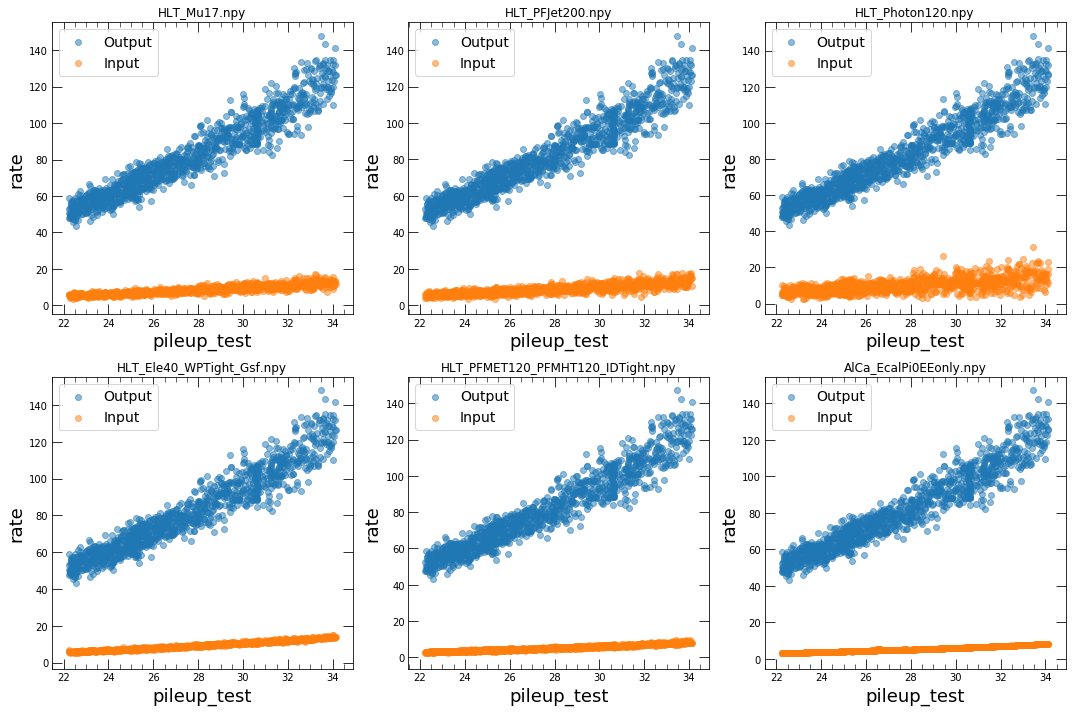

In [22]:
pileup_test = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_test)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_test[r][o]*pileup_test[r])
        input_rates[o].append(x_test[r][o]*pileup_test[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_test,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_test,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup_test')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Fake Bad Data

In [23]:
one_bad = np.array(data[str(runs[2])]['bad_samples'])

In [24]:
reconstructed_one_bad = model.predict(np.array(one_bad))

error_one_bad = abs(one_bad-reconstructed_one_bad)/one_bad

In [25]:
error_reformat_one_bad = []
inp_one_bad = []
outp_one_bad = []
for i in range(num_rates):
    error_reformat_one_bad.append([])
    inp_one_bad.append([])
    outp_one_bad.append([])

for i in range(len(error_one_bad)):
    for j in range(num_rates):
        error_reformat_one_bad[j].append(error_one_bad[i][j])
        outp_one_bad[j].append(reconstructed_one_bad[i][j])
        inp_one_bad[j].append(one_bad[i][j])
            
        

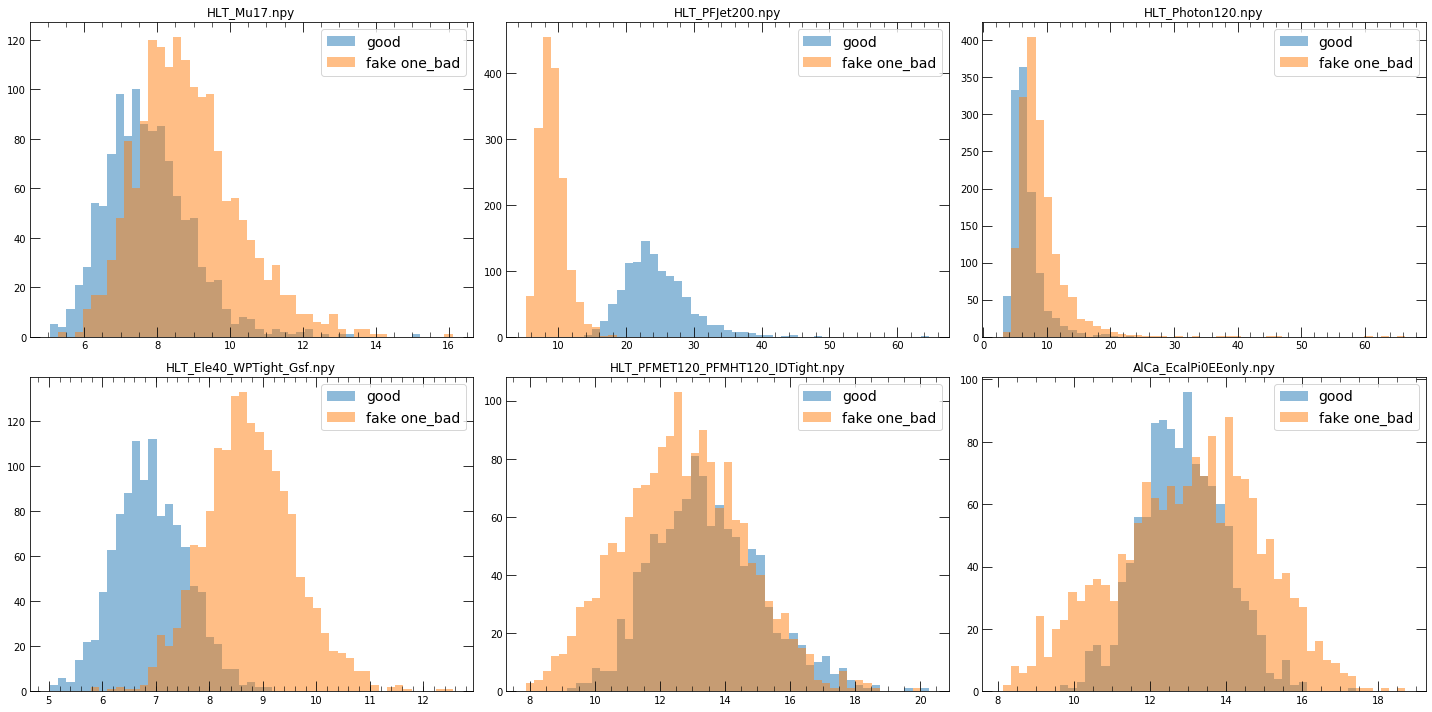

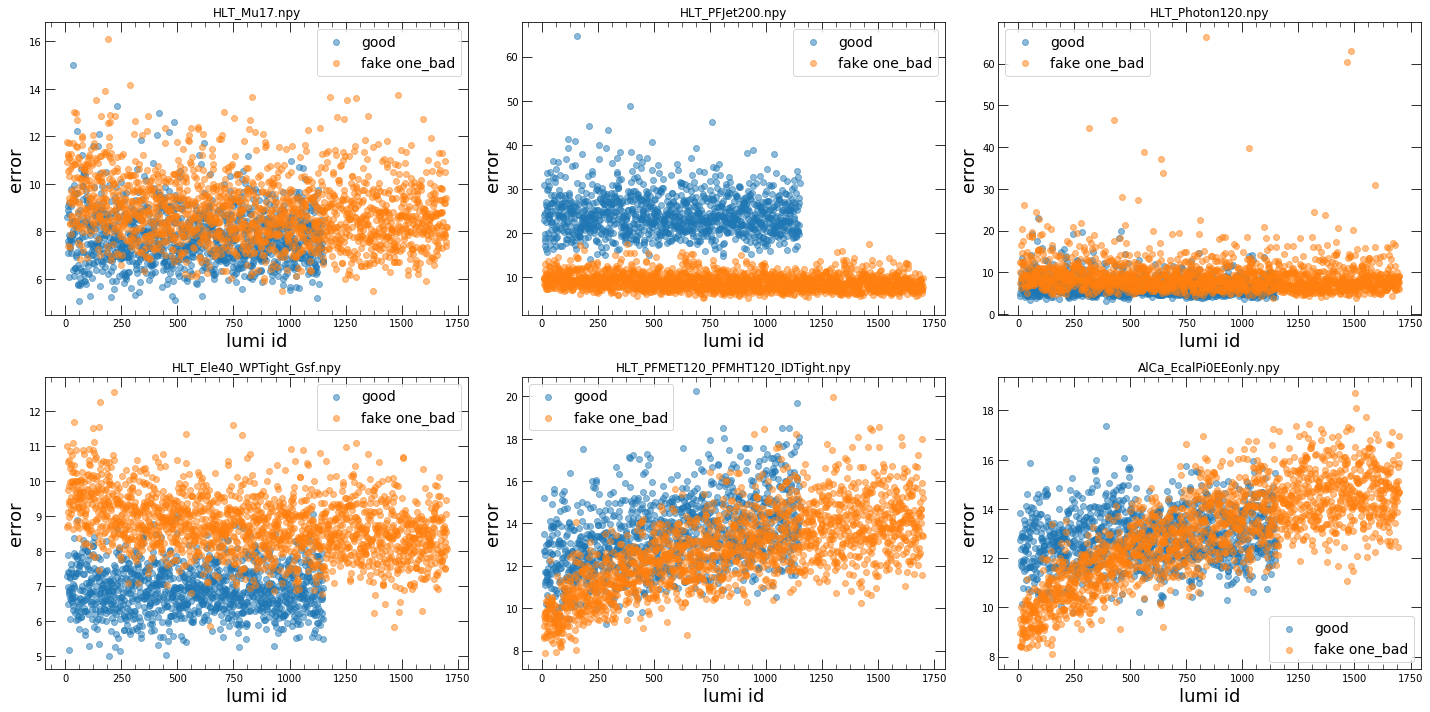

In [26]:
#bins = np.linspace(0,1,50)
bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_one_bad)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_train_reformat[i]),min(error_reformat_one_bad[i])),max(max(error_train_reformat[i]),max(error_reformat_one_bad[i])),50)
    plt.hist(error_reformat_one_bad[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_train_reformat[i],bins=bins,label='fake one_bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi_one_bad = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_one_bad[0]),len(error_reformat_one_bad0]),len(lumi_one_bad))
#lumi_one_bad = np.linspace(0,len(error_reformat_one_bad[0]),len(error_reformat_one_bad[0]))
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_one_bad,error_reformat_one_bad[i],label = 'good', alpha =.5)
    plt.scatter(lumi_train,error_train_reformat[i],label='fake one_bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

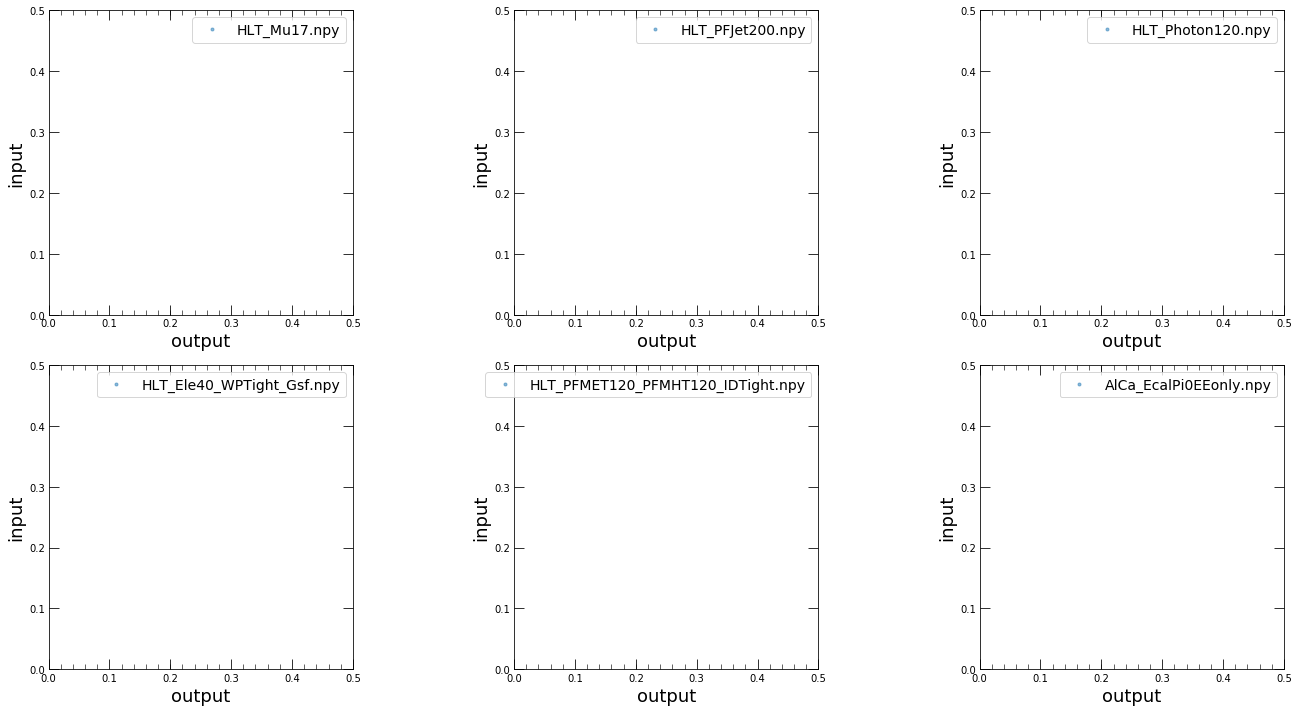

In [27]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_one_bad[i],inp_one_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,.5)
    plt.ylim(0,.5)
    plt.legend()    
plt.tight_layout()
plt.show()

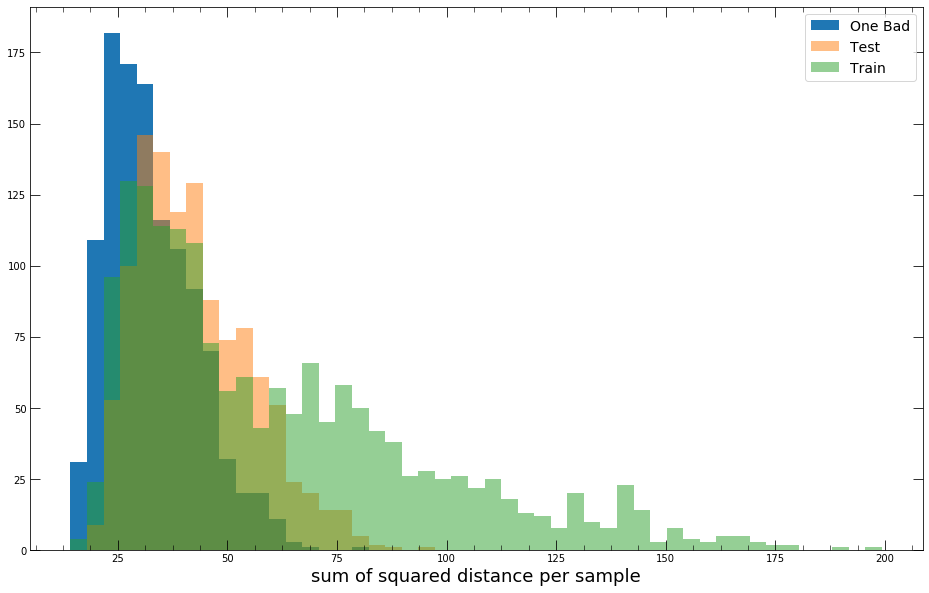

In [28]:
error_one_bad = []
for r in range(len(reconstructed_one_bad)):
    temp = 0
    for s in range(len(reconstructed_one_bad[r])):
        temp+=(reconstructed_one_bad[r][s]-one_bad[r][s])**2
    error_one_bad.append(temp)

plt.figure()
bins = np.linspace(min(min(error_train),min(error_one_bad),min(error_test)),max(max(error_train),max(error_test),max(error_one_bad)),50)
plt.hist(error_one_bad,bins=bins,label="One Bad")
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.show()

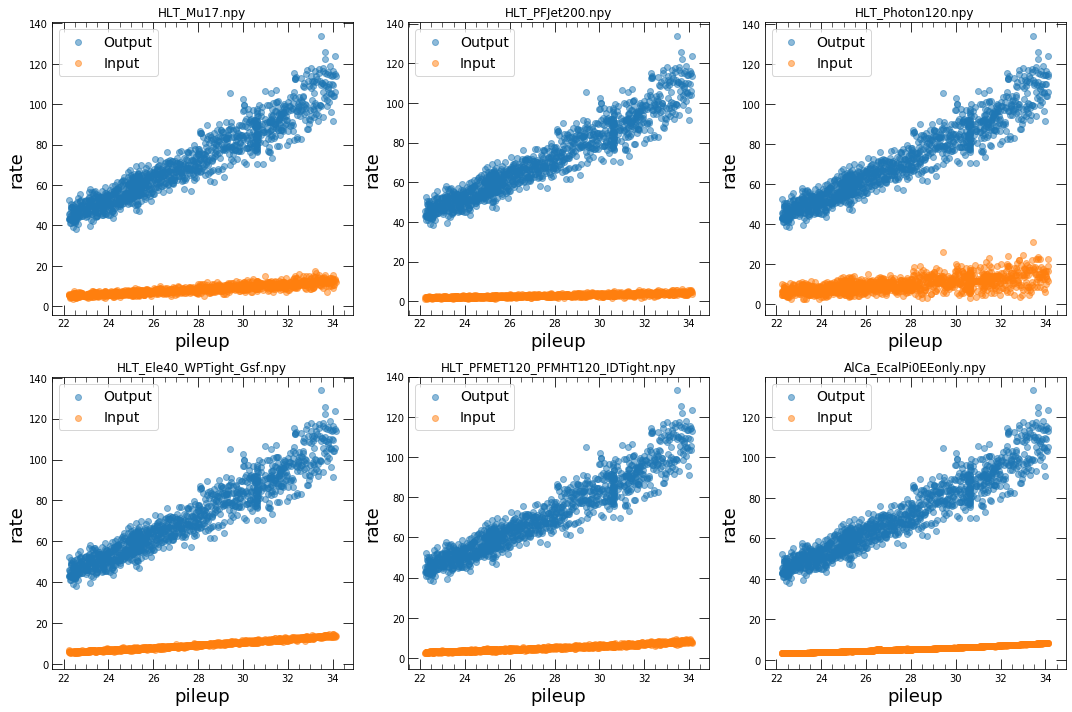

In [29]:
pileup_one_bad = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_one_bad)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_one_bad[r][o]*pileup_one_bad[r])
        input_rates[o].append(one_bad[r][o]*pileup_one_bad[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_one_bad,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_one_bad,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Fake Bad Data - ALL

In [30]:
all_bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [31]:
reconstructed_all_bad = model.predict(np.array(all_bad))

error_all_bad = abs(all_bad-reconstructed_all_bad)/all_bad

In [32]:
error_reformat_all_bad = []
inp_all_bad = []
outp_all_bad = []
for i in range(num_rates):
    error_reformat_all_bad.append([])
    inp_all_bad.append([])
    outp_all_bad.append([])

for i in range(len(error_all_bad)):
    for j in range(num_rates):
        error_reformat_all_bad[j].append(error_all_bad[i][j])
        outp_all_bad[j].append(reconstructed_all_bad[i][j])
        inp_all_bad[j].append(all_bad[i][j])
            
        

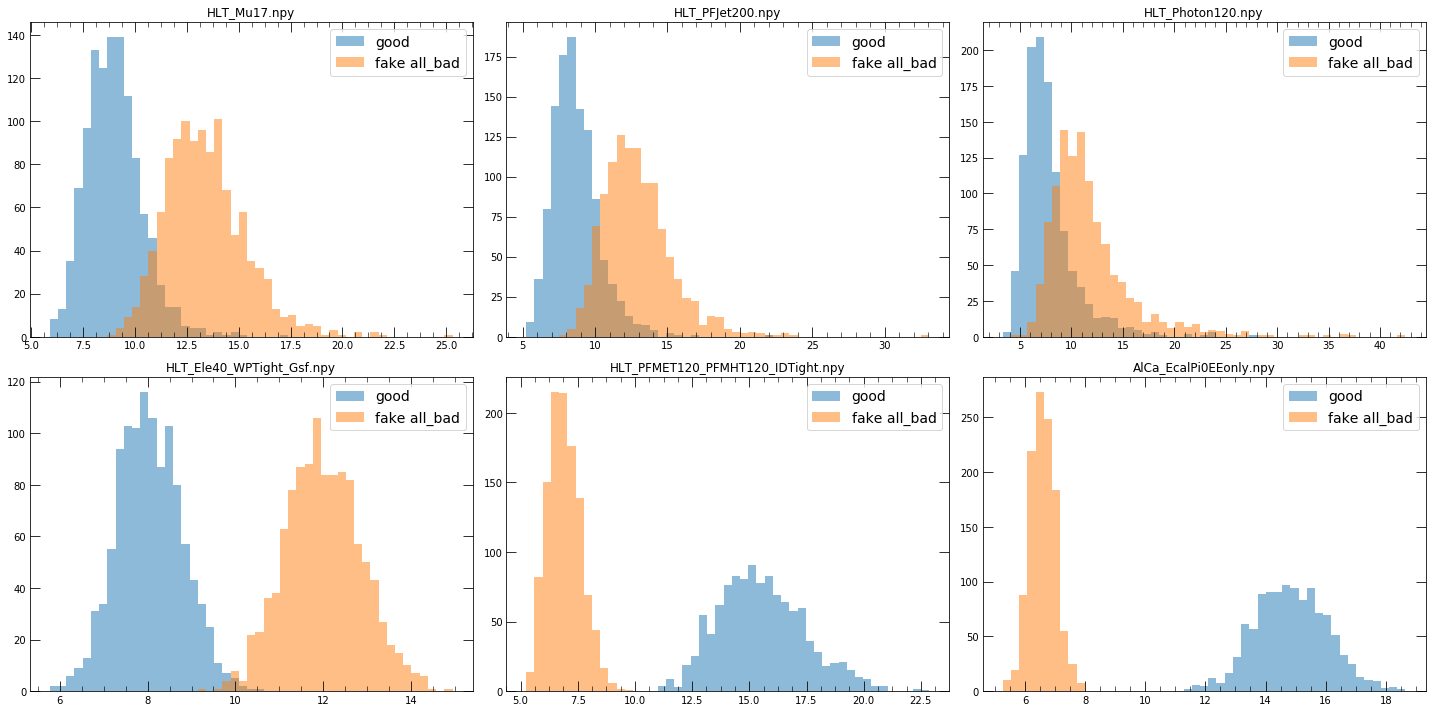

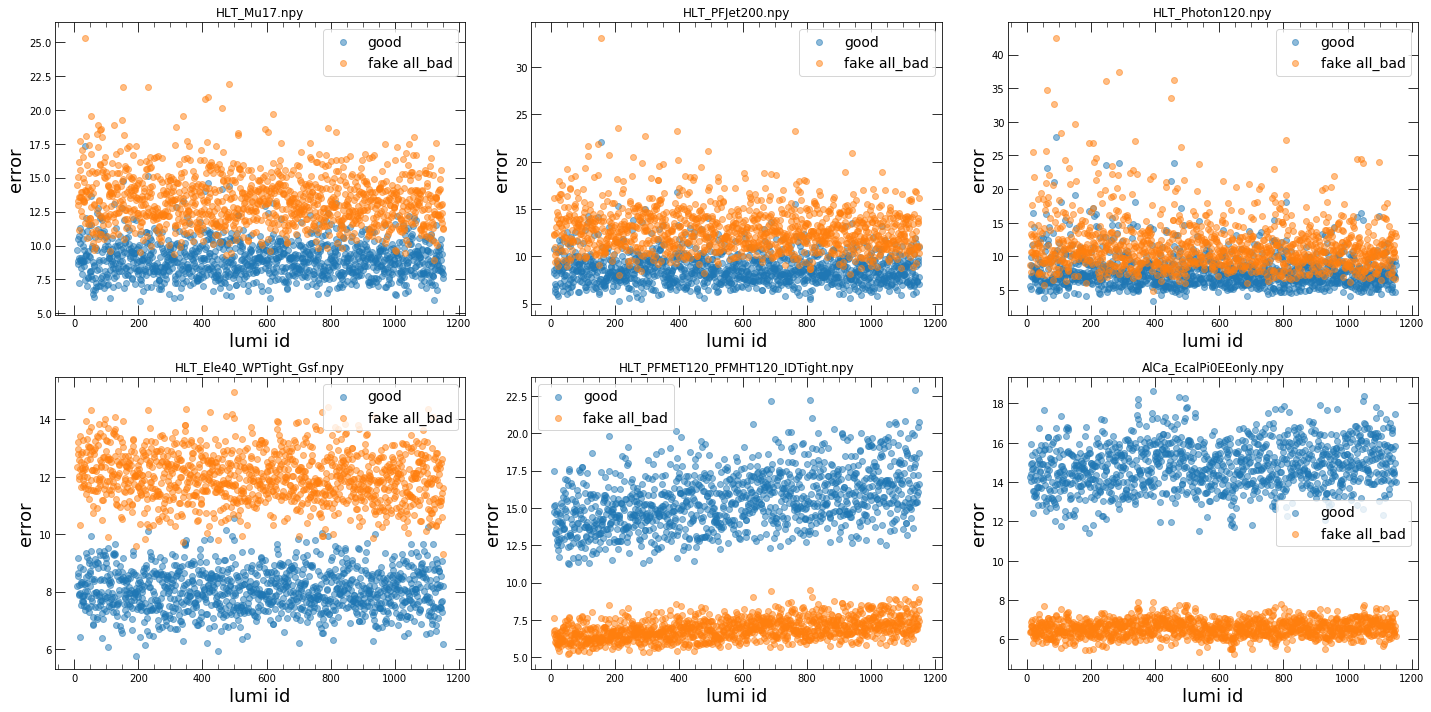

In [33]:
#bins = np.linspace(0,1,50)
bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_all_bad)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_all_bad[i])),max(max(error_test_reformat[i]),max(error_reformat_all_bad[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_all_bad[i],bins=bins,label='fake all_bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi_all_bad = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_all_bad[0]),len(error_test_reformat0]),len(lumi_all_bad))
#lumi_all_bad = np.linspace(0,len(error_reformat_all_bad[0]),len(error_reformat_all_bad[0]))
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi_all_bad,error_reformat_all_bad[i],label='fake all_bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

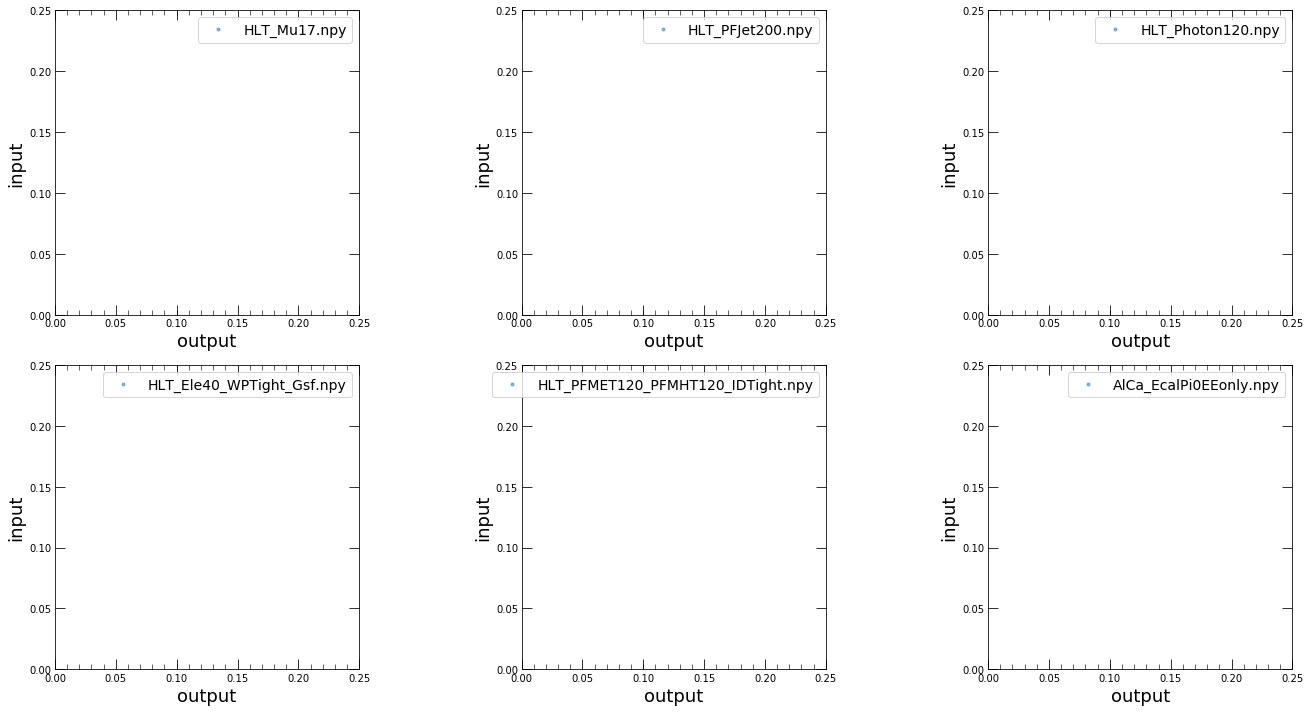

In [34]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_all_bad[i],inp_all_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,.25)
    plt.ylim(0,.25)
    plt.legend()    
plt.tight_layout()
plt.show()

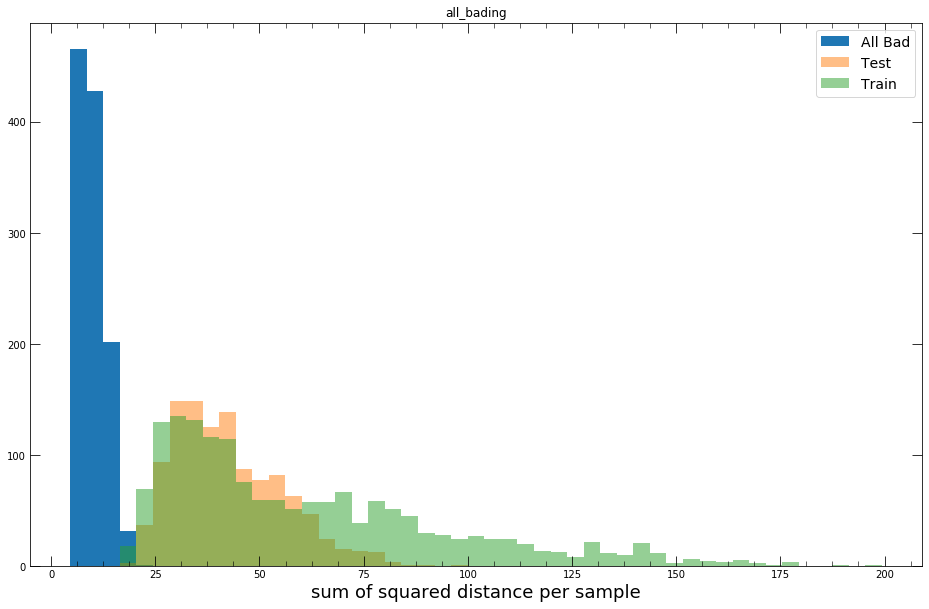

In [35]:
error_all_bad = []
for r in range(len(reconstructed_all_bad)):
    temp = 0
    for s in range(len(reconstructed_all_bad[r])):
        temp+=(reconstructed_all_bad[r][s]-all_bad[r][s])**2
    error_all_bad.append(temp)

plt.figure()
bins = np.linspace(min(min(error_test),min(error_train),min(error_all_bad)),max(max(error_test),max(error_train),max(error_all_bad)),50)
plt.hist(error_all_bad,bins=bins,label="All Bad")
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.title('all_bading')
plt.show()

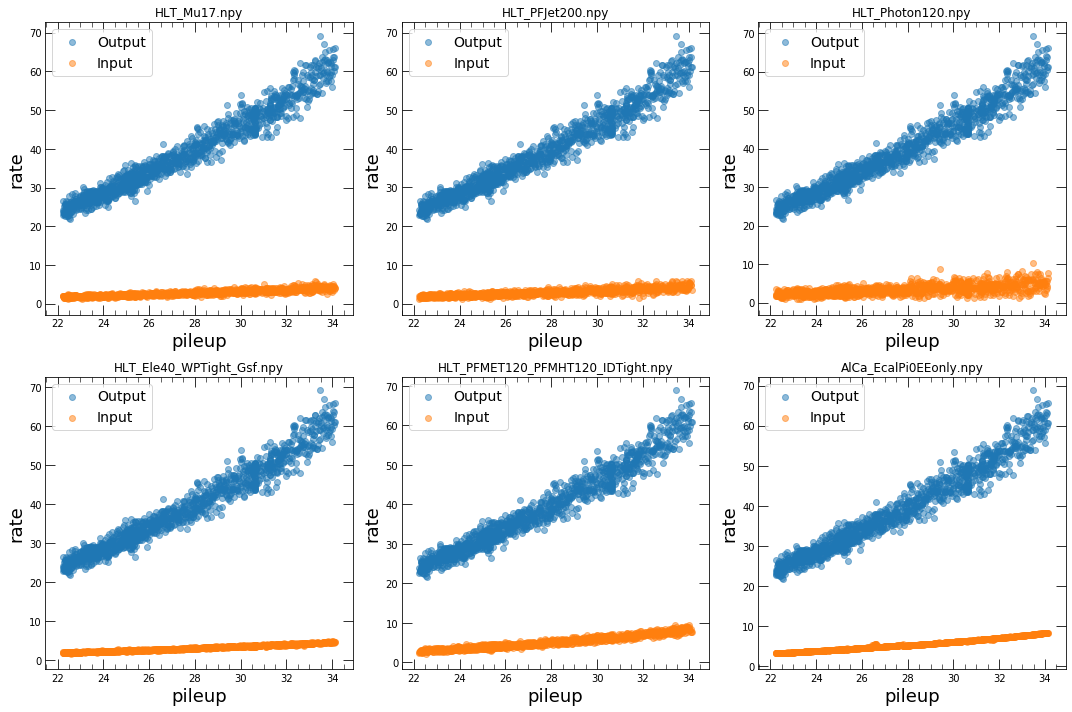

In [36]:
pileup_all_bad = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_all_bad)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_all_bad[r][o]*pileup_all_bad[r])
        input_rates[o].append(all_bad[r][o]*pileup_all_bad[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_all_bad,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_all_bad,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Real Bad Data

In [37]:
with open(bad_data_file, 'rb') as handle:
    baddata = pickle.load(handle)

realbad2_runs = [301480]
x_bad2 = np.array(baddata[str(realbad2_runs[0])]['samples'])

real_bad = {}
real_bad.update({'301480' : {}})

In [38]:
realbad2_new = []
lumi_realbad2 = []
pileup = []
pile = baddata[str(realbad2_runs[0])]['pileup'][0]
lumirealbad2 = baddata[str(realbad2_runs[0])]['lumiid']

for l in range(len(x_bad2)):
    if not 0 in x_bad2[l]:
        realbad2_new.append(x_bad2[l])
        lumi_realbad2.append(lumirealbad2[l])
        pileup.append(pile[l])
            
lumirealbad2 = []
for n in lumi_realbad2:
    if n not in lumirealbad2:
        lumirealbad2.append(n)
    
                
reconstructed_realbad2 = model.predict(np.array(realbad2_new))

error_realbad2 = abs(realbad2_new-reconstructed_realbad2)/realbad2_new

real_bad["301480"].update({"input" : realbad2_new})
real_bad["301480"].update({"output" : reconstructed_realbad2})

In [39]:
error_reformat_realbad2 = []
inp_realbad2 = []
outp_realbad2 = []
for i in range(num_rates):
    error_reformat_realbad2.append([])
    inp_realbad2.append([])
    outp_realbad2.append([])

for i in range(len(error_realbad2)):
    for j in range(num_rates):
        error_reformat_realbad2[j].append(error_realbad2[i][j])
        outp_realbad2[j].append(reconstructed_realbad2[i][j])
        inp_realbad2[j].append(realbad2_new[i][j])

real_bad["301480"].update({"relative error" : error_reformat_realbad2})

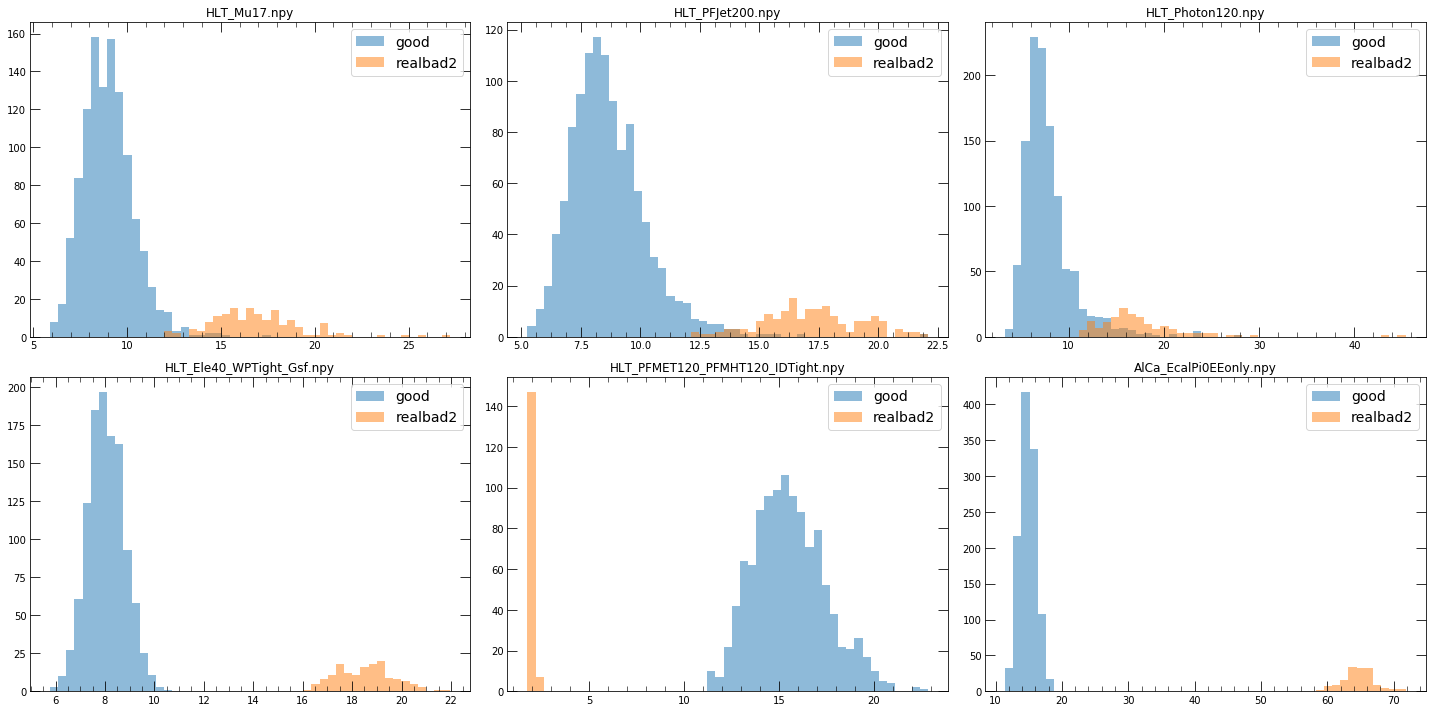

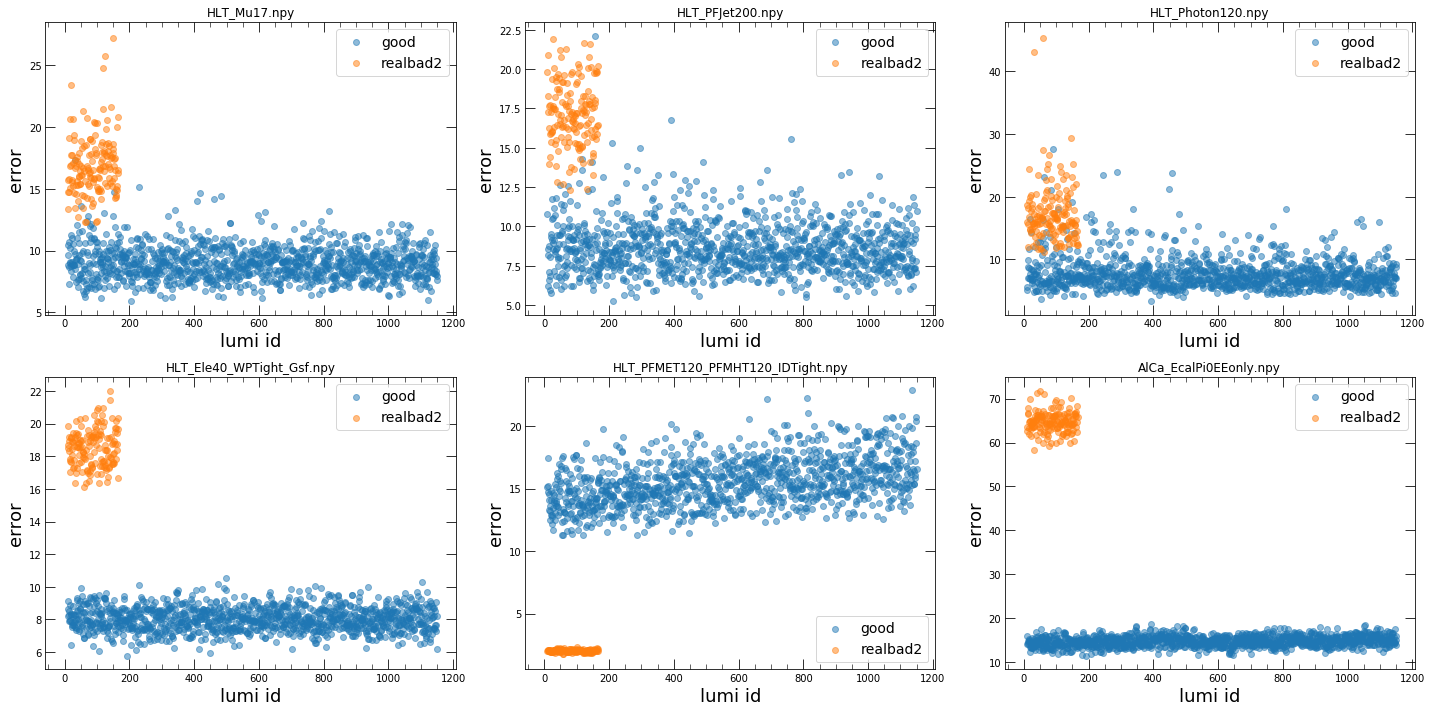

In [40]:
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_realbad2)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_realbad2[i])),max(max(error_test_reformat[i]),max(error_reformat_realbad2[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_realbad2[i],bins=bins,label='realbad2',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumirealbad2,error_reformat_realbad2[i],label='realbad2',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

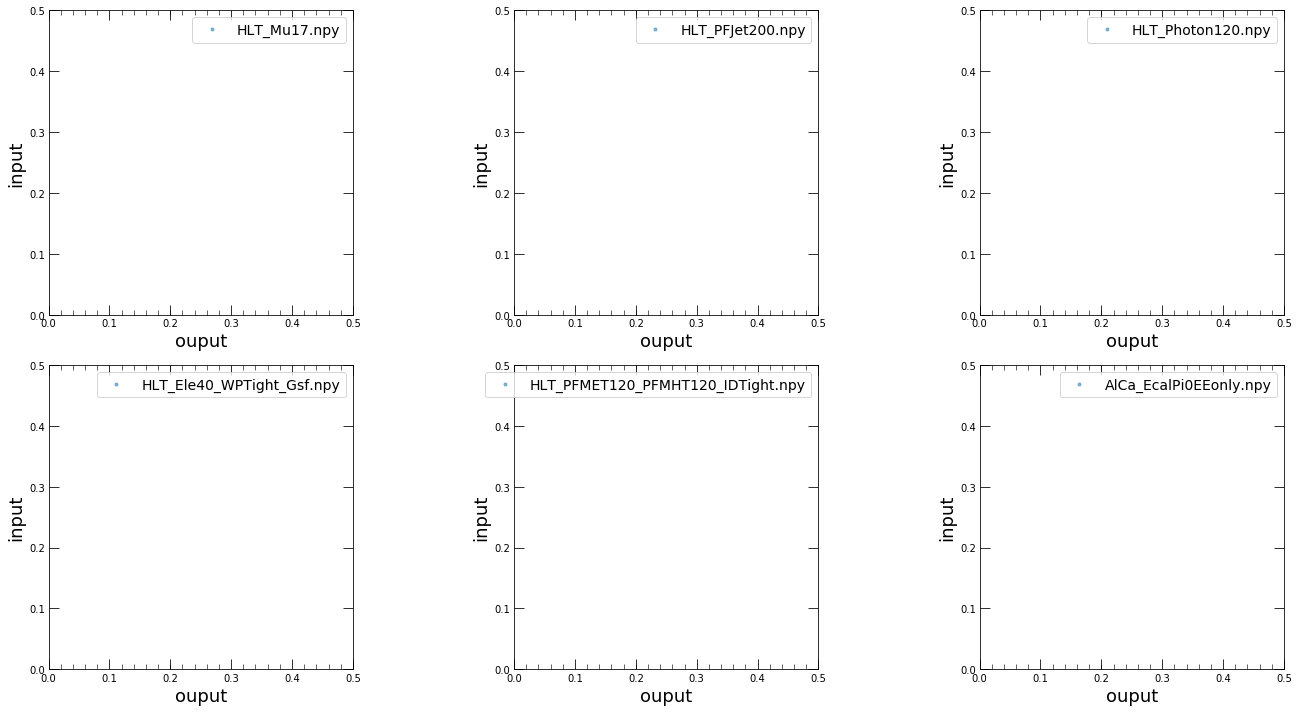

In [41]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_realbad2[i],inp_realbad2[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,.5)
    plt.ylim(0,.5)
    plt.legend()    
plt.tight_layout()
plt.show()

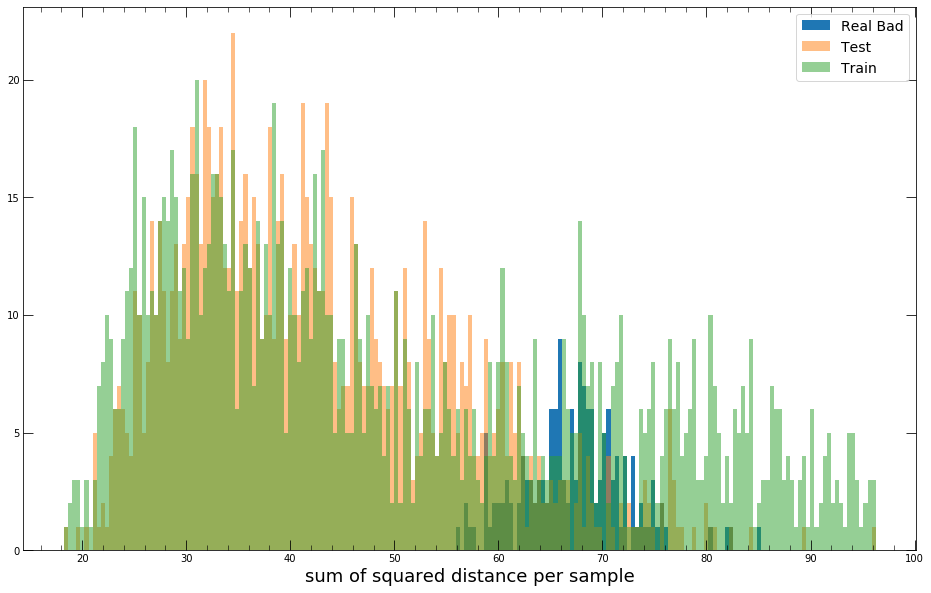

In [42]:
error_realbad2 = []
for r in range(len(reconstructed_realbad2)):
    temp = 0
    for s in range(len(reconstructed_realbad2[r])):
        temp+=(reconstructed_realbad2[r][s]-realbad2_new[r][s])**2
    error_realbad2.append(temp)

real_bad["301480"].update({"squared difference" : error_realbad2})

plt.figure()
bins = np.linspace(min(min(error_test),min(error_realbad2)),max(max(error_test),max(error_realbad2)),200)
plt.hist(error_realbad2,bins=bins,label='Real Bad')
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.legend()
plt.xlabel('sum of squared distance per sample')
plt.show()

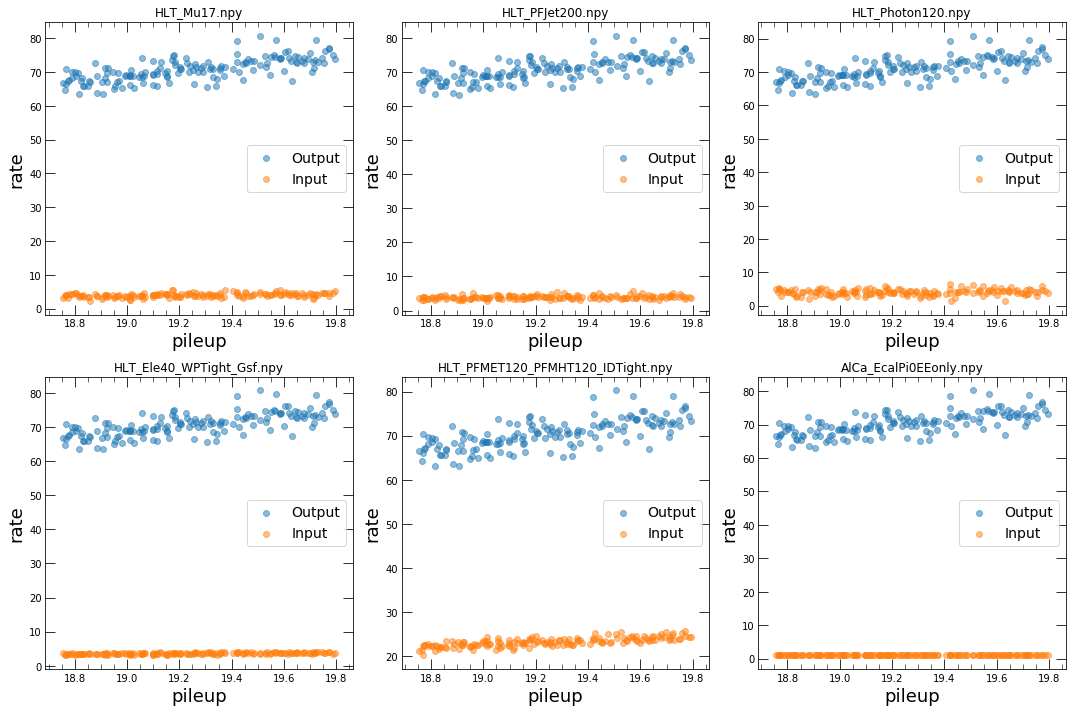

In [43]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_realbad2)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_realbad2[r][o]*pileup[r])
        input_rates[o].append(realbad2_new[r][o]*pileup[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Real Bad Data

In [44]:
realbad1_runs = [305588]
x_bad1 = np.array(baddata[str(realbad1_runs[0])]['samples'])

In [45]:
realbad1_new = []
lumi_realbad1 = []
pileup = []
pile = baddata[str(realbad1_runs[0])]['pileup'][0]
lumirealbad1 = baddata[str(realbad1_runs[0])]['lumiid']

for l in range(len(x_bad1)):
    if not 0 in x_bad1[l]:
        realbad1_new.append(x_bad1[l])
        lumi_realbad1.append(lumirealbad1[l])
        pileup.append(pile[l])
            
lumirealbad1 = []
for n in lumi_realbad1:
    if n not in lumirealbad1:
        lumirealbad1.append(n)
    
                
reconstructed_realbad1 = model.predict(np.array(realbad1_new))

error_realbad1 = abs(realbad1_new-reconstructed_realbad1)/realbad1_new

In [46]:
error_reformat_realbad1 = []
inp_realbad1 = []
outp_realbad1 = []
for i in range(num_rates):
    error_reformat_realbad1.append([])
    inp_realbad1.append([])
    outp_realbad1.append([])

for i in range(len(error_realbad1)):
    for j in range(num_rates):
        error_reformat_realbad1[j].append(error_realbad1[i][j])
        outp_realbad1[j].append(reconstructed_realbad1[i][j])
        inp_realbad1[j].append(realbad1_new[i][j])

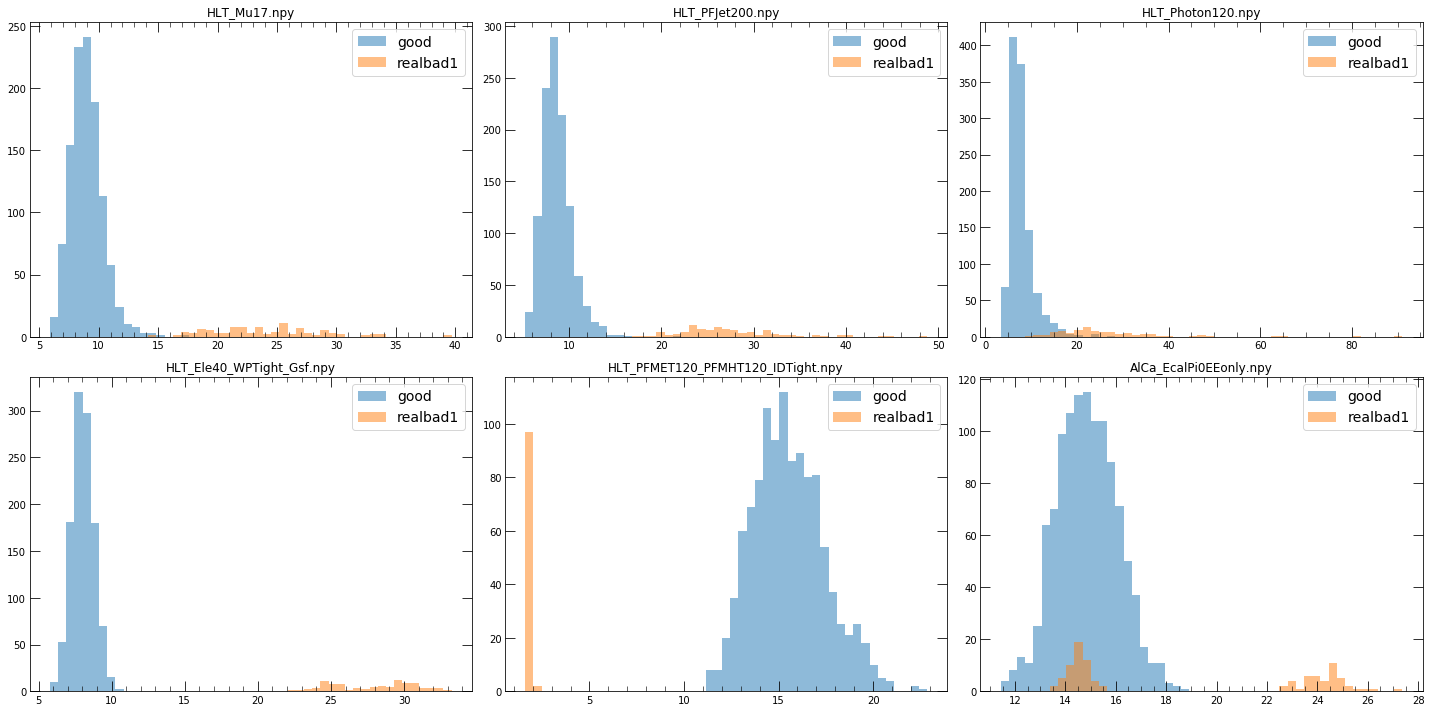

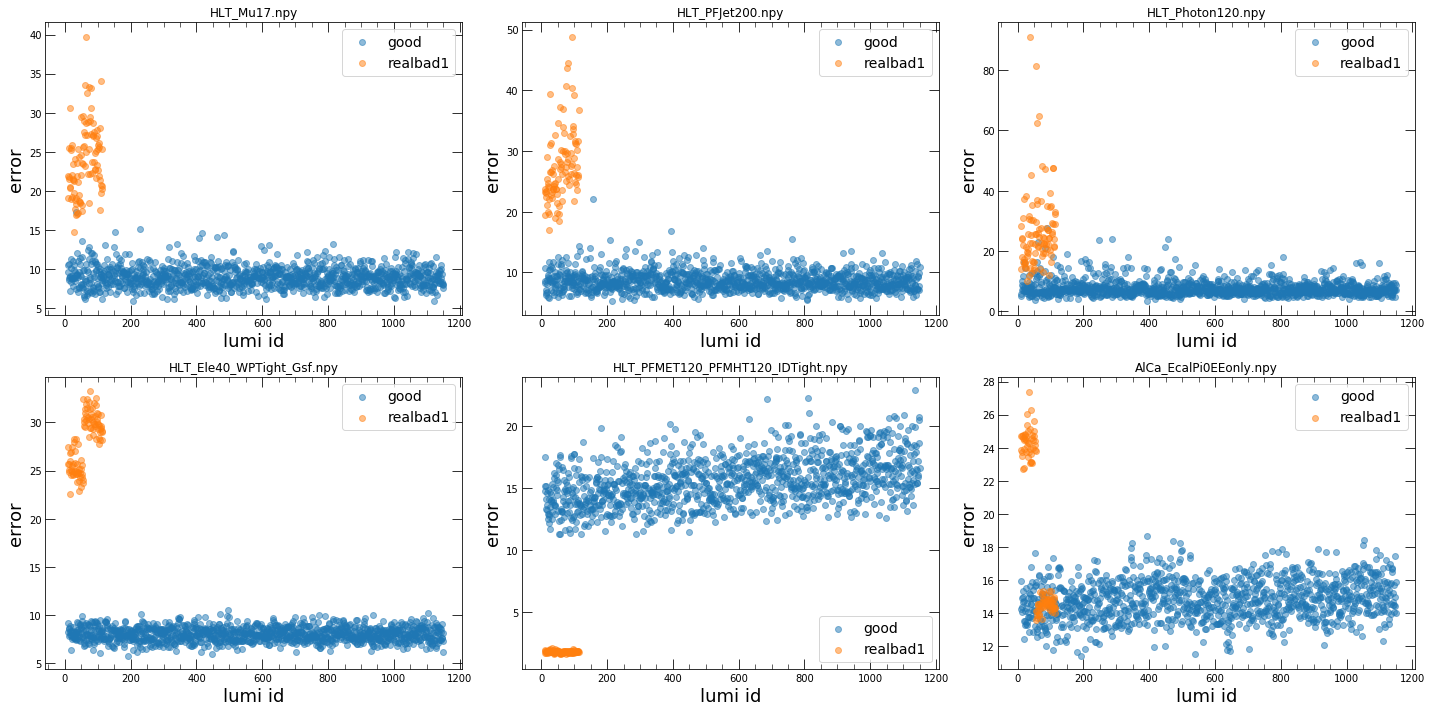

In [47]:
bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_realbad1)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_realbad1[i])),max(max(error_test_reformat[i]),max(error_reformat_realbad1[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_realbad1[i],bins=bins,label='realbad1',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumirealbad1,error_reformat_realbad1[i],label='realbad1',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

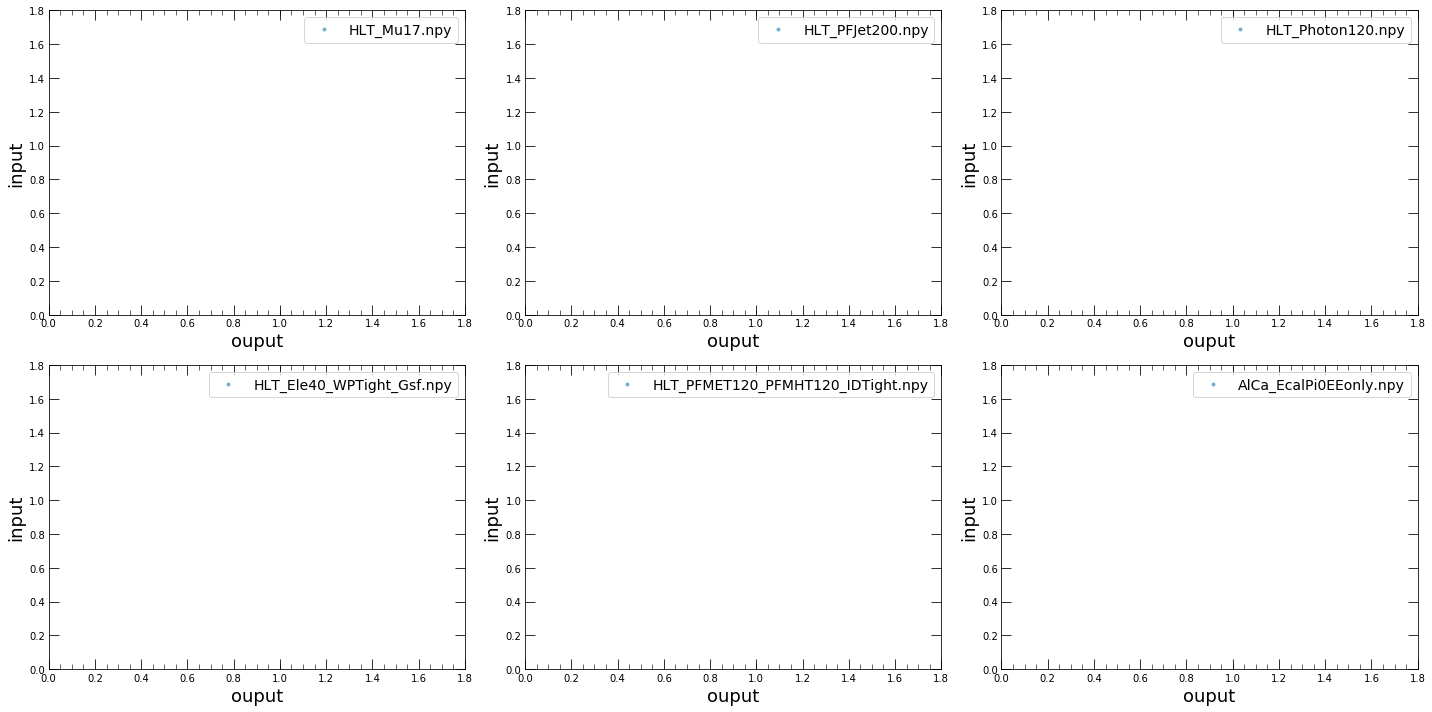

In [48]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_realbad1[i],inp_realbad1[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    plt.xlim(0,1.8)
    plt.ylim(0,1.8)
    plt.legend()    
plt.tight_layout()
plt.show()

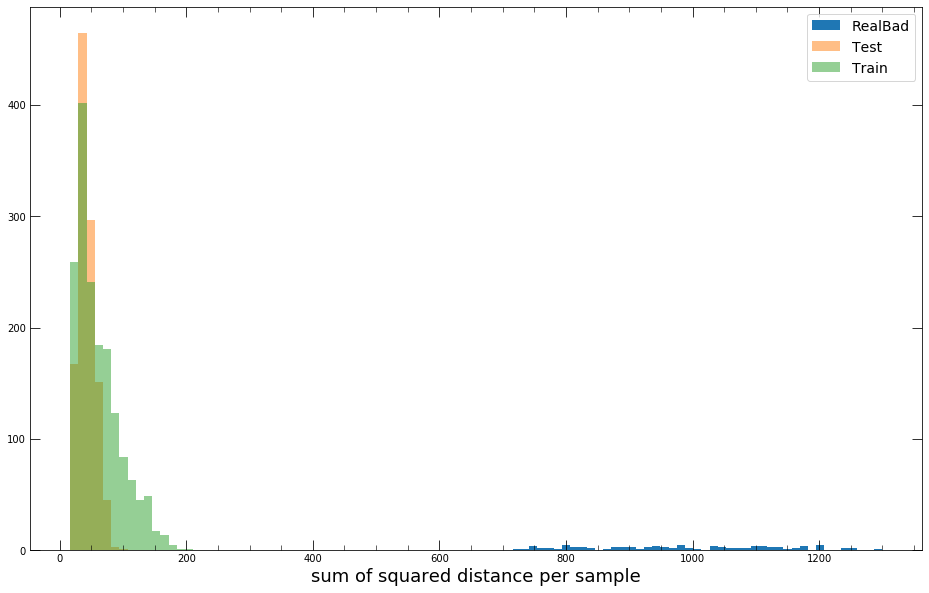

In [49]:
error_realbad1 = []
for r in range(len(reconstructed_realbad1)):
    temp = 0
    for s in range(len(reconstructed_realbad1[r])):
        temp+=(reconstructed_realbad1[r][s]-realbad1_new[r][s])**2
    error_realbad1.append(temp)

plt.figure()
bins = np.linspace(min(min(error_realbad1),min(error_test),min(error_train)),max(max(error_realbad1),max(error_test),max(error_train)),100)
plt.hist(error_realbad1,bins=bins,label='RealBad')
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.xlabel('sum of squared distance per sample')
plt.legend()
plt.show()

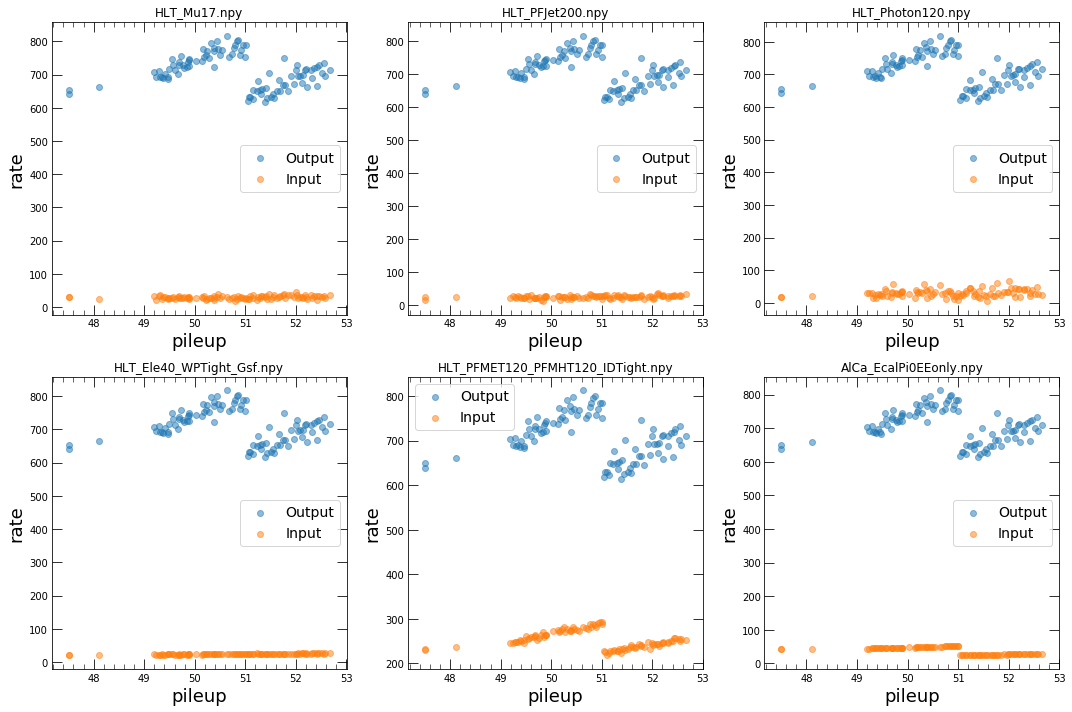

In [50]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_realbad1)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_realbad1[r][o]*pileup[r])
        input_rates[o].append(realbad1_new[r][o]*pileup[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

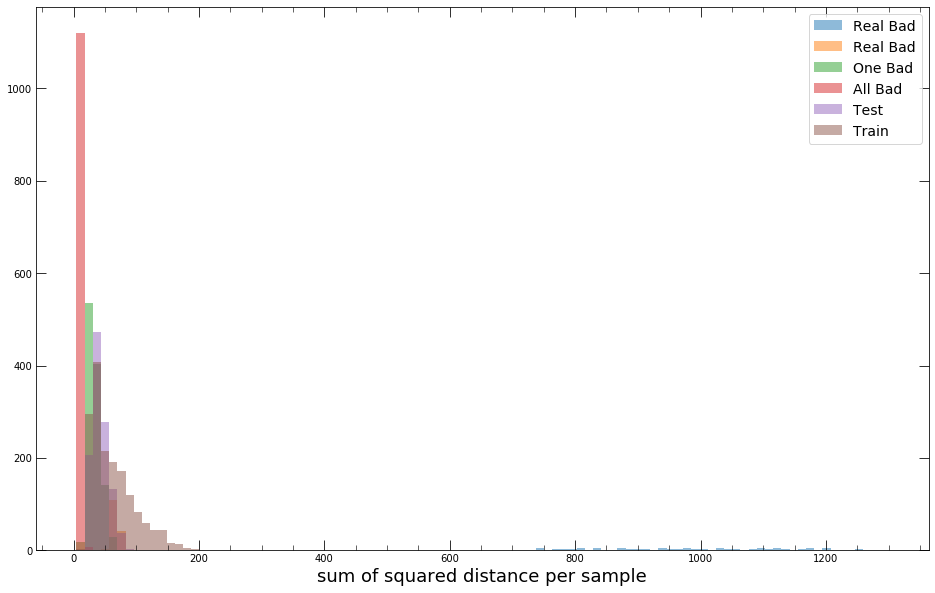

In [51]:
plt.figure()
bins = np.linspace(min(min(error_realbad1),min(error_test),min(error_train),min(error_realbad2),min(error_one_bad),min(error_all_bad)),max(max(error_realbad1),max(error_test),max(error_train),max(error_realbad2),max(error_one_bad),max(error_all_bad)),100)
plt.hist(error_realbad1,bins=bins,label='Real Bad',alpha=.5)
plt.hist(error_realbad2,bins=bins,label='Real Bad',alpha=.5)
plt.hist(error_one_bad,bins=bins,label='One Bad',alpha=.5)
plt.hist(error_all_bad,bins=bins,label='All Bad',alpha=.5)
plt.hist(error_test,bins=bins,label='Test',alpha=.5)
plt.hist(error_train,bins=bins,label='Train',alpha=.5)
plt.xlabel('sum of squared distance per sample')
plt.legend()
#plt.ylim(0,100)
plt.show()